# Skill assessment - Ebro
***

**Author**: Chus Casado<br>
**Date**: 25-01-2023<br>

**Index**<br>
[__1 Data__](#1-Data)<br>
[1.1 Stations](#1.1-Stations)<br>
[1.2 Exceedance reanalysis](#1.2-Exceedance-reanalysis)<br>
[1.3 Exceedance forecast](#1.3-Exceedance-forecast)<br>
[__2 Compute events__](#2-Compute-events)<br>
[__3 Assess skill__](#3-Assess-skill)<br>

**Introduction**:<br>


**Questions**:<br>

* Should we resample to 12-hourly timesteps?
* What if every event is supposed to last 12 h?

**Tasks to do**:<br>

* [ ] Compute skill only in stations with a KGE over a threshold.
* [ ] Average `f1` score for each station.


**Interesting links**<br>
[Pythonic way to perform statistics across multiple variables with Xarray](https://towardsdatascience.com/pythonic-way-to-perform-statistics-across-multiple-variables-with-xarray-d0221c78e34a)

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

path_root = os.getcwd()
path_forecast = '../data/CDS/forecast/'

import warnings
warnings.filterwarnings("ignore")

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

os.chdir('../py/')
from notifications import *
os.chdir(path_root)

## 1 Data

In [2]:
catchment = 'Ebro'

# shapefile with rivers
rivers = gpd.read_file(f'../data/GIS/rivers_{catchment}.shp')

### 1.1 Stations 

In [3]:
# load selected points
stations = pd.read_csv(f'results/{catchment}/points_selected.csv', index_col='station_id')
n_stations = stations.shape[0]
print('no. stations:\t{0}'.format(n_stations))

# add columns where skill will be saved
new_cols = [f'f1_{model}' for model in ['current', 'model_mean', 'weighted_mean']]
stations[new_cols] = np.nan

no. stations:	50


### 1.2 Exceedance reanalysis

In [4]:
# load probability of exceeding the discharge threshold in the REANALYSIS data
path_reanalysis = '../data/exceedance/reanalysis/'
rean_events = pd.read_parquet(f'{path_reanalysis}/events_rl5.parquet')
rean_events.columns = rean_events.columns.astype(int)
rean_events = rean_events[stations.index.tolist()]

### 1.3 Exceedance forecast

In [5]:
# models
models = {'COS': {'members': 20, 'leadtimes': 23},
          'DWD': {'members': 1, 'leadtimes': 29},
          'EUD': {'members': 1, 'leadtimes': 41},
          'EUE': {'members': 51, 'leadtimes': 41},}

In [6]:
# load probability of exceeding the discharge threshold in the FORECAST data
path_forecast = '../data/exceedance/forecast/'

fore_exc = {}
for stn in stations.index:
    fore_exc[stn] = xr.open_dataarray(f'{path_forecast}{stn:04d}.nc')

# convert into a Dataset
stn = stations.index[0]
fore_exc = xr.Dataset(fore_exc, coords={'model': fore_exc[stn].model, 'forecast': fore_exc[stn].forecast, 'leadtime': fore_exc[stn].leadtime})

# convert the dataset into a DataArray in which models is a dimension instead of different variables
# da_list = [ds[stn].expand_dims('id', axis=0).assign_coords(id=[stn]).rename('exceedance') for stn in stations.index]
# da = xr.merge(da_list)['exceedance']

In [7]:
# DataArray with weights for each model and leadtime
weights = np.zeros((len(fore_exc.model), len(fore_exc.leadtime)))
for i, (key, value) in enumerate(models.items()):
    leadtimes = value['leadtimes']
    members = value['members']
    weights[i,:leadtimes] = members
weights = xr.DataArray(weights, coords={'model': list(models), 'leadtime': fore_exc.leadtime})

## 2. Compute events

In [8]:
# probability thresholds
probabilities = np.arange(0.05, .96, .05).round(2)

In [9]:
# compute observed events and predicted events
obs_events = {}
pred_events = {}
for i, stn in enumerate(stations.index):  
    
    print(f'Station {stn:>4d} ({i+1:>4d} of {n_stations:>4d})', end='\r')

    # OBSERVED EVENTS
    # ...............
    
    # find events
    mask = rean_events[stn]
    events = rean_events.index[mask].tolist()
    # create DataArray of the occurrence of events
    obs_events[stn] = dataarray_events(events, fore_exc.forecast, fore_exc.leadtime)
    
    # COMPUTE MODEL COMBINATIONS
    # ..........................

    # mean across equally-weighted models
    model_mean = fore_exc[stn].mean('model')
    model_mean = model_mean.expand_dims('model', axis=0).assign_coords(model=['model_mean']).rename(stn)

    # weighted-mean across models
    weighted_mean = fore_exc[stn].weighted(weights).mean('model')
    weighted_mean = weighted_mean.expand_dims('model', axis=0).assign_coords(model=['weighted_mean']).rename(stn)

    # join all exceedance DataArrays
    exceedance = xr.merge([fore_exc[stn], model_mean, weighted_mean])[stn]

    pred_events_stn = xr.DataArray(dims=['model', 'forecast', 'leadtime', 'probability'],
                                   coords={'model': ['current', 'model_mean', 'weighted_mean'],
                                         'forecast': exceedance.forecast,
                                         'leadtime': exceedance.leadtime,
                                         'probability': probabilities})
    
    for j, p in enumerate(probabilities):
        
        # TIMSTEPS AT WHICH CRITERIA IS MET
        # .................................
        
        # dataset where all criteria will ve saved
        criteria = xr.Dataset(coords={'forecast': exceedance.forecast,
                                      'leadtime': exceedance.leadtime})

        # boolean auxiliary Dataset of exceedance over threshold
        aux = exceedance > p

        # find where the deterministic criteria was fulfilled
        deterministic = aux.sel(model=['DWD', 'EUD']).sum('model')
        # find where the probabilistic criteria was fulfilled
        probabilistic = aux.sel(model=['COS', 'EUE']).sum('model')
        # find where both the deterministic and the probabilistic criteria was fulfilled
        criteria['current'] = ((deterministic >= 1) & (probabilistic >= 1))
        # find where the combinations of models exceeds the probability threshold 
        for model in ['model_mean', 'weighted_mean']:
            criteria[model] = aux.sel(model=model)
        # remove variable model
        criteria = criteria.drop_vars('model')

        # FORECAST EVENTS
        # ...............

        # compute the onset of the events
        steps = criteria.astype(int).diff('leadtime') == 1
        step0 = criteria.isel(leadtime=0)
        onsets = xr.concat((step0, steps), 'leadtime')
        da_list = [onsets[model].expand_dims('model', axis=0).assign_coords(model=[model]).rename('event') for model in list(onsets)]
        onsets = xr.merge(da_list)['event']

        pred_events_stn.loc[dict(probability=p)] = onsets
        
    pred_events[stn] = pred_events_stn

obs_events = xr.Dataset(obs_events).to_array(dim='id', name='events')
pred_events = xr.Dataset(pred_events).to_array(dim='id', name='events')

## 3 Assess skill

In [10]:
metrics = {'f1': f1_score,
           'precision': precision_score,
           'recall': recall_score}

### 3.1 By forecast

In [11]:
# observed events in each forecast
obs_ld = obs_events.any('leadtime')

# predicted events in each forecast
pred_ld = pred_events.any('leadtime')

In [12]:
# Dataset where results will be saved
aux = xr.DataArray(dims=['id', 'model', 'probability'], 
                   coords={'id': pred_ld.id, 'model': pred_ld.model, 'probability': pred_ld.probability})
results1 = xr.Dataset({metric: aux.copy() for metric in metrics})

for i, stn in enumerate(results1.id.data):
    for j, model in enumerate(results1.model.data):
        for k, p in enumerate(results1.probability.data):
        
            print('Station {0:>4d} ({1:>3d} of {2:>3d}) - {3:<13} - probability {4:.0f}%'.format(stn, i+1, len(results1.id), model, p * 100),
                  end='\r')
            
            # extract observed and predicted events
            obs = obs_ld.sel(id=stn)
            loc = {'id': stn, 'model': model, 'probability': p}
            pred = pred_ld.sel(loc)
            
            # compute performance
            if obs.any() | pred.any():
                for key, func in metrics.items():
                    results1[key].loc[loc] = func(obs.data, pred.data)

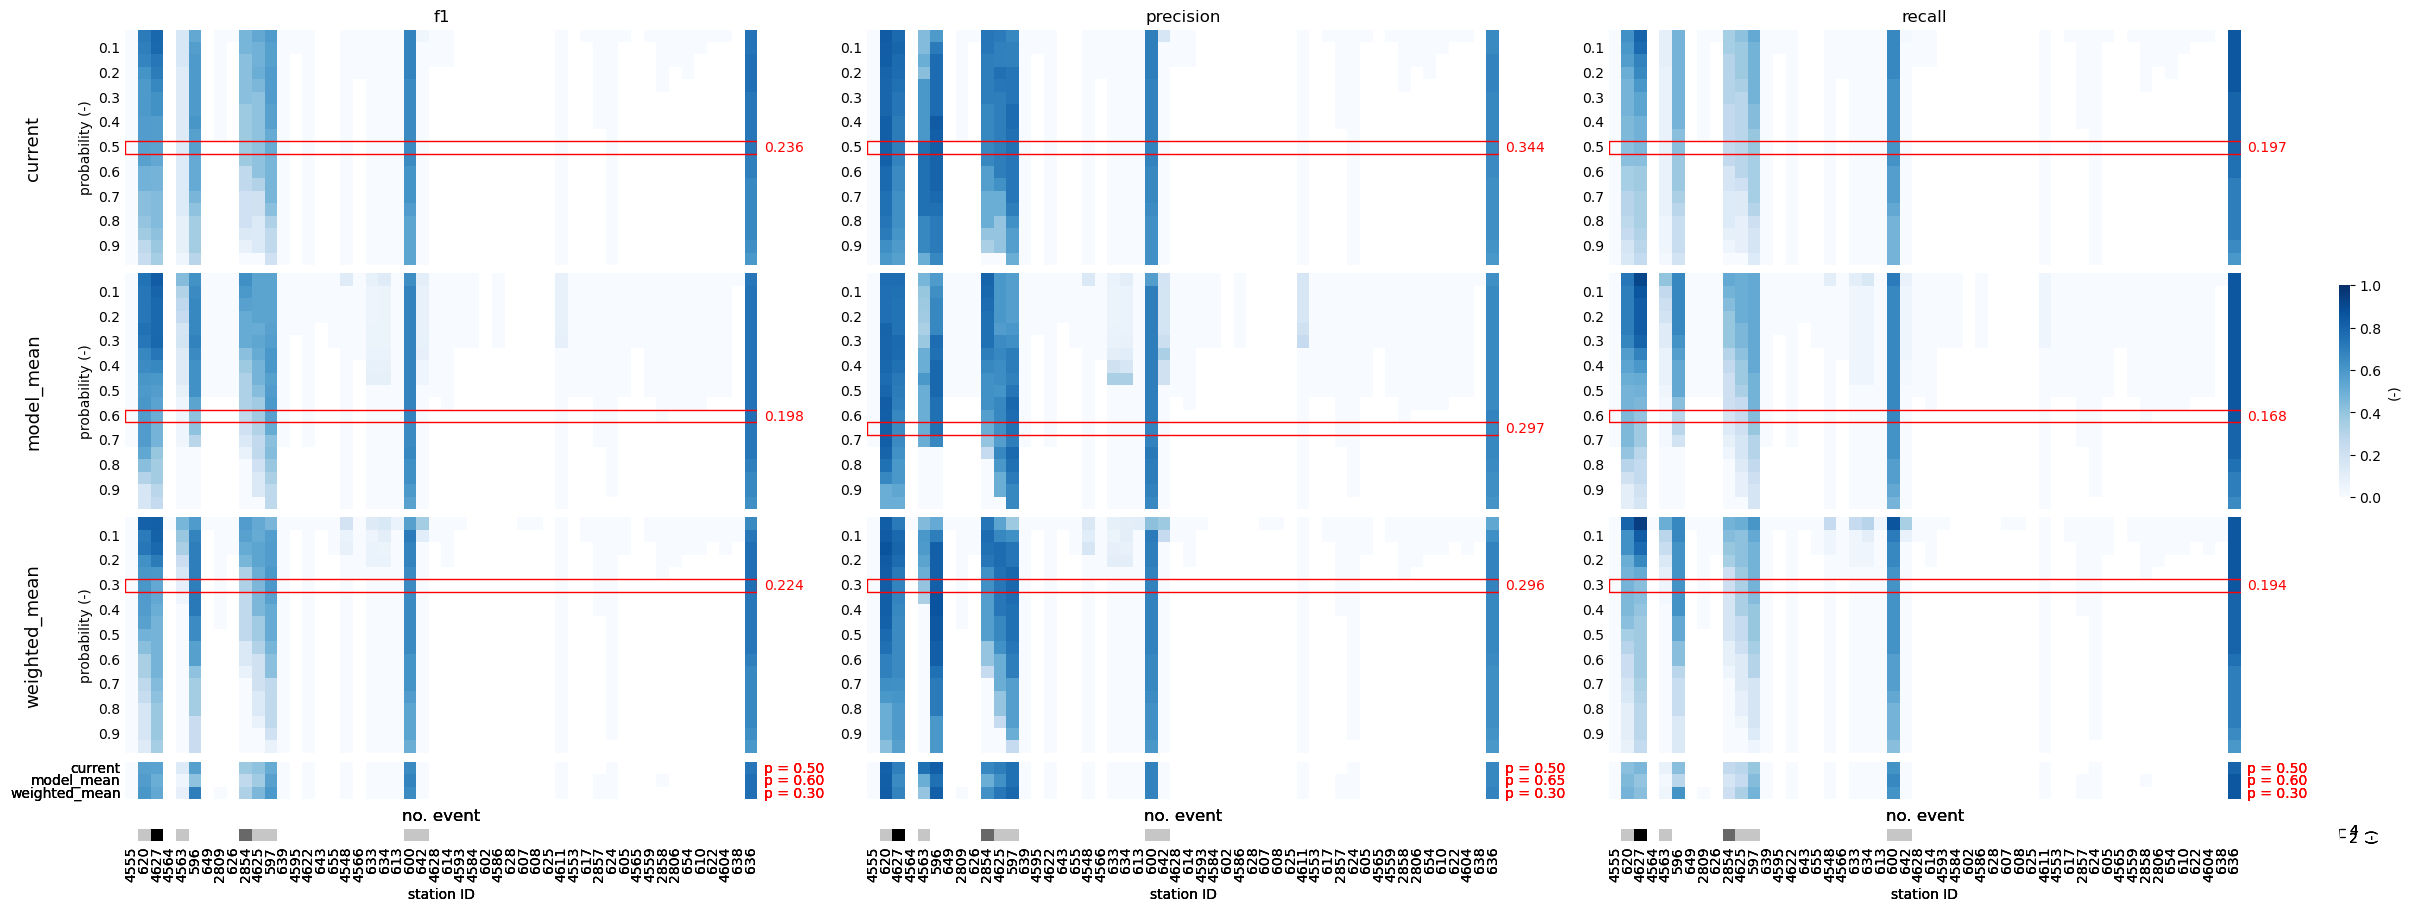

In [13]:
# plot results
plot_skill(results1, rean_events.sum())

The plot above shows the performance in terms of forecasts that predicted a flood and the flood actually occurred. The leadtime for the flood is not taking into account at this point; I consider a hit a forecast that predicts a flood at any leadtime and there actually was a flood during the complete forecasted period. 

The graph contains 15 plots distributed in 3 columns and 5 rows. Each column represents a metric: f1 (the harmonic mean of precision and recall), precision (proportion of predicted floods that were right), and recall (proportion of observed floods that were predicted). The top 3 rows represent each of the prediction criteria; they are heatmaps of the corresponding metric depending on the station and the probability threshold; the red rectangle shows the best probability threshold for that specific criteria and metric. The plots in the fourth row aggregate the red rectangles in a single plot to ease the comparison among criteria. The plots in the last row show for the amount of forecast with flood events; it is the same plot for the 3 columns.

The outcome is very interesting. In 15 out of the 50 stations there are observed events. However, there are only 9 stations in which floods are somehow predicted (metric values over 0.3). If we look at the plots in the fourth row, we check that in approx. a half of the stations (27 out of 50) there weren't neither predicted nor observed events (blank cells). However, this number of stations without predicted floods varies a lot depending on the model and the probability threshold; the lower the threshold, the more floods are predicted, reducing the overall scores.

The _current_ model get the higher score for each of the three metrics. However, to obtain these scores the probability threshold must be raised from the current 30% to 50%. The second highest ranking criteria is the *weighted_mean*, for which the best probability threshold is the current 30%. In general, the three criteria show higher precision than recall, i.e., it's likelier to be correct when it predicts a flood, but it misses observed floods. Overall, the mean scores are low. This might be caused by two factors. First, in this analysis we combine all leadtimes, which reduces the average score because distant leadtimes are more difficult to predict. Second, the low average scores are caused by some stations with poor values; if we check the plots in the fourth row, there are 9 stations with rather high scores and 14 stations with rather low scores. Interestingly, the well-performing stations are not that sensitive to the probability threshold, whereas the bad performing are. Basically, the best probability threshold is that that minimizes the amount of poor-performing stations.

In [ ]:
# # export stations table with the skill score

# da = results1['f1']

# # probability with highest mean score
# best_model = da.mean('id').idxmax('probability')
# best_model_i = da.mean('id').argmax('probability')

# # score values for each station with the previous probability
# best_metric_model = xr.DataArray(dims=['model', 'id'], coords={'model': da.model, 'id': da.id})
# for model in best_model.model:
#     p = best_model.sel(model=model)
#     best_metric_model.loc[dict(model=model)] = da.sel(model=model, probability=p)

# for model in best_metric_model.model.data:
#     f1 = best_metric_model.sel(model=model).to_pandas()
#     stations.loc[f1.index, f'f1_{model}'] = f1

# # export 
# stations.to_csv(f'results/{catchment}/stations_f1.csv', float_format='%.3f')

### 3.2 Regardless leadtime

In [14]:
# number of timesteps surrounding the actual event
windows = [1, 3, 5]

# Dataset where results will be saved
aux = xr.DataArray(dims=['id', 'model', 'probability', 'window'], 
                   coords={'id': pred_ld.id, 'model': pred_ld.model, 'probability': pred_ld.probability, 'window': windows})
results2 = xr.Dataset({metric: aux.copy() for metric in metrics})

for i, stn in enumerate(results2.id.data):
    
    # extract observed and predicted events
    obs = obs_events.sel(id=stn)
    
    for w in results2.window.data:
        # compute predicted events according to the rolling sum
        mp = int(w / 2) + 1
        pred_w = pred_events.rolling({'leadtime': w}, center=True, min_periods=mp).sum() > 0
    
        
        for model in results2.model.data:
            for p in results2.probability.data:

                print('Station {0:>4d} ({1:>3d} of {2:>3d}) - window {5} - {3:<13} - probability {4:.0f}%'.format(stn, i+1, len(results2.id), model, p * 100, w),
                      end='\r')

                # extract observed and predicted events
                loc = {'id': stn, 'model': model, 'probability': p}
                pred = pred_w.sel(loc)

                # compute performance
                if obs.any() | pred.any():
                    for key, func in metrics.items():
                        loc = loc = {'id': stn, 'model': model, 'probability': p, 'window': w}
                        results2[key].loc[loc] = func(obs.data.flatten(), pred.data.flatten())

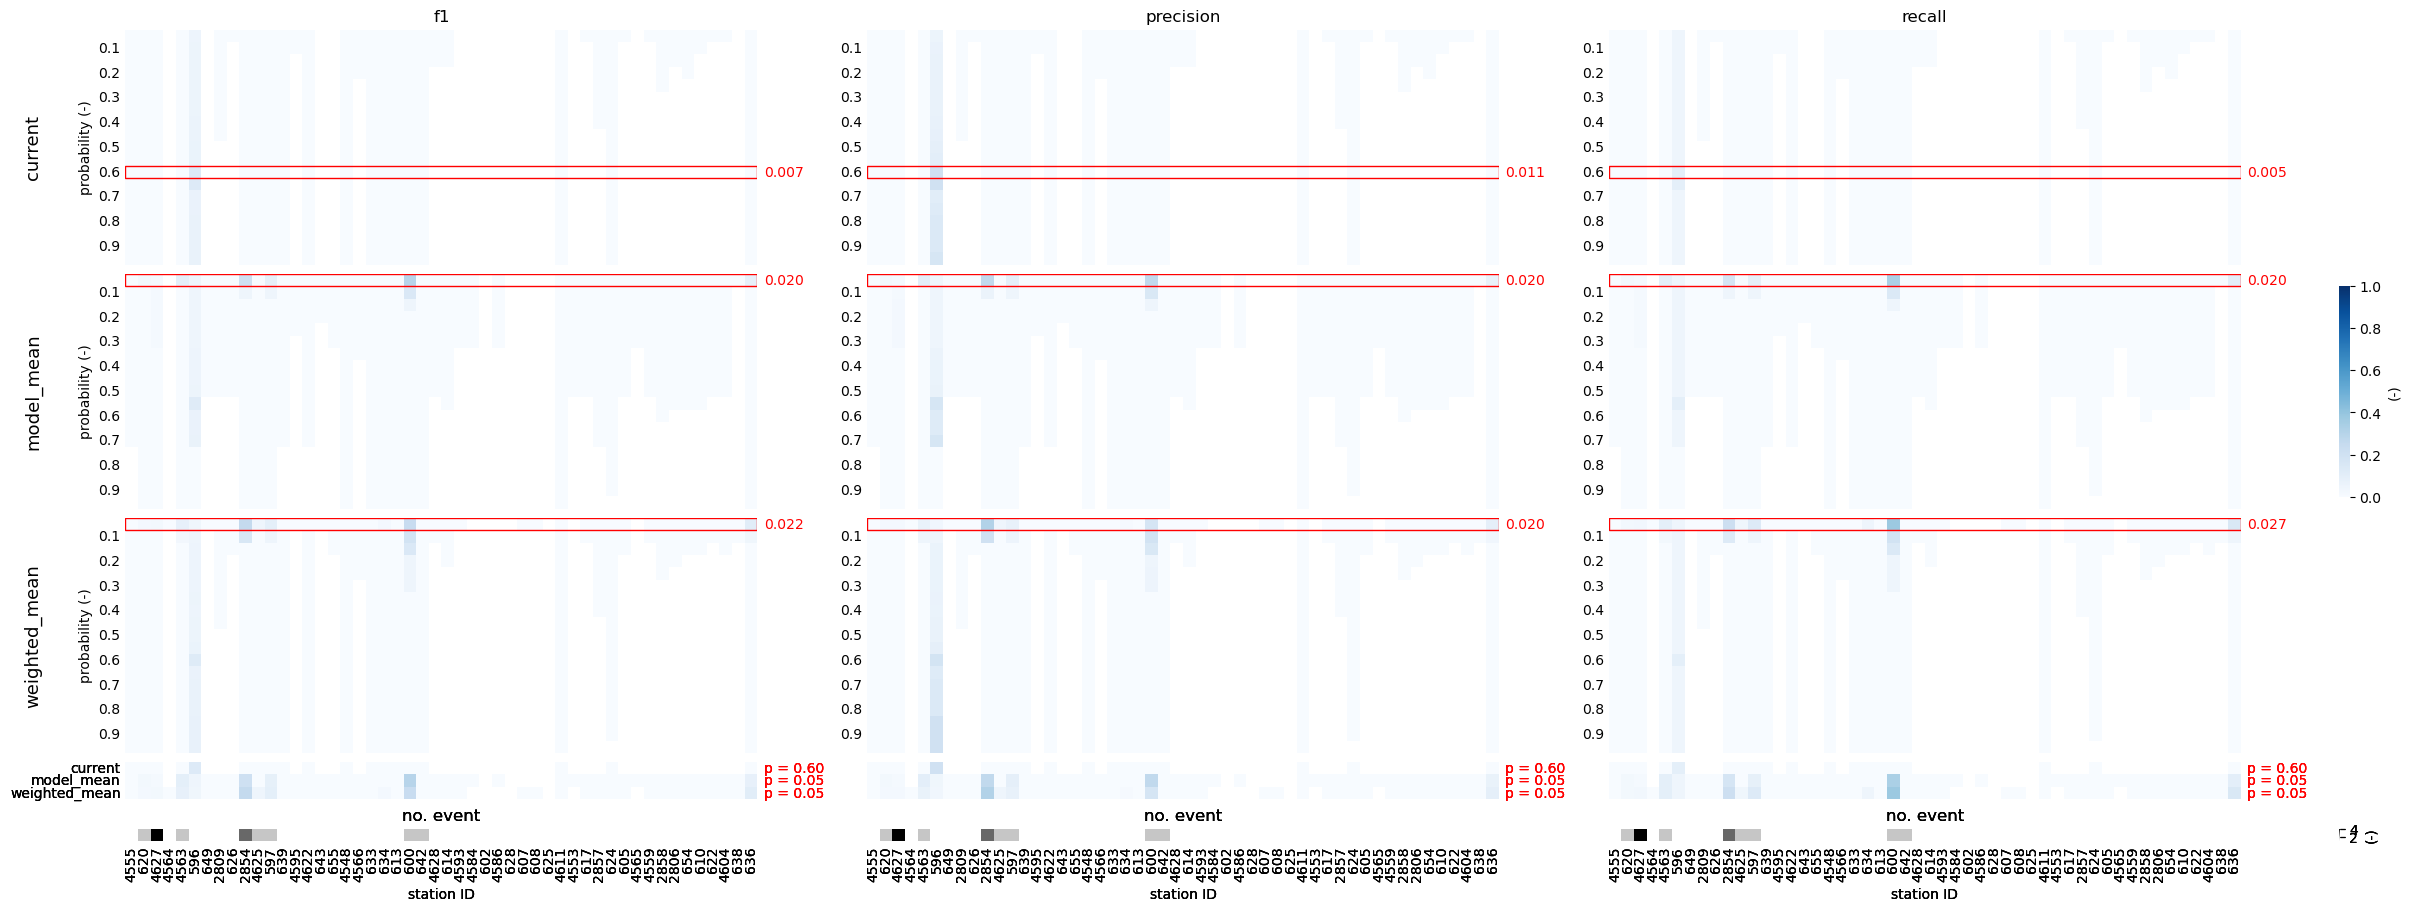

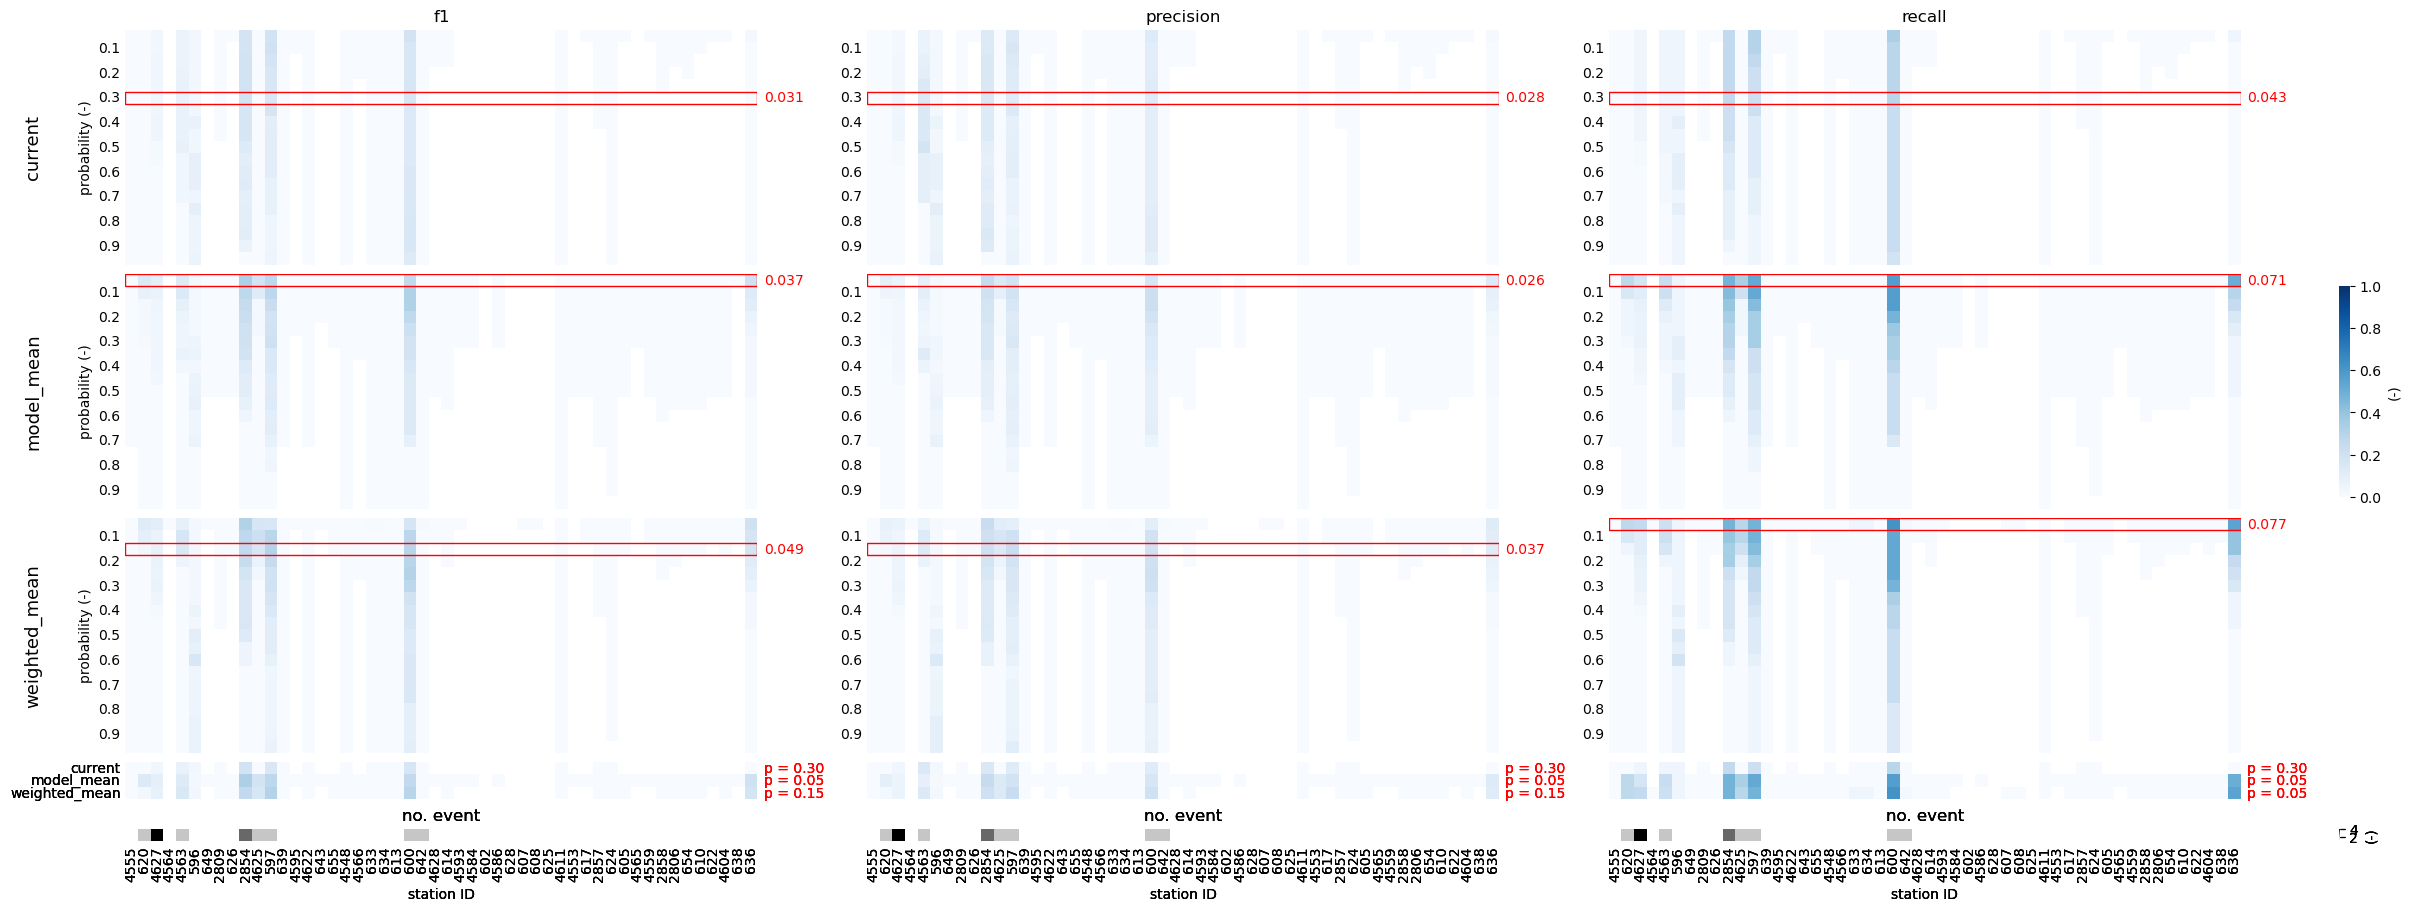

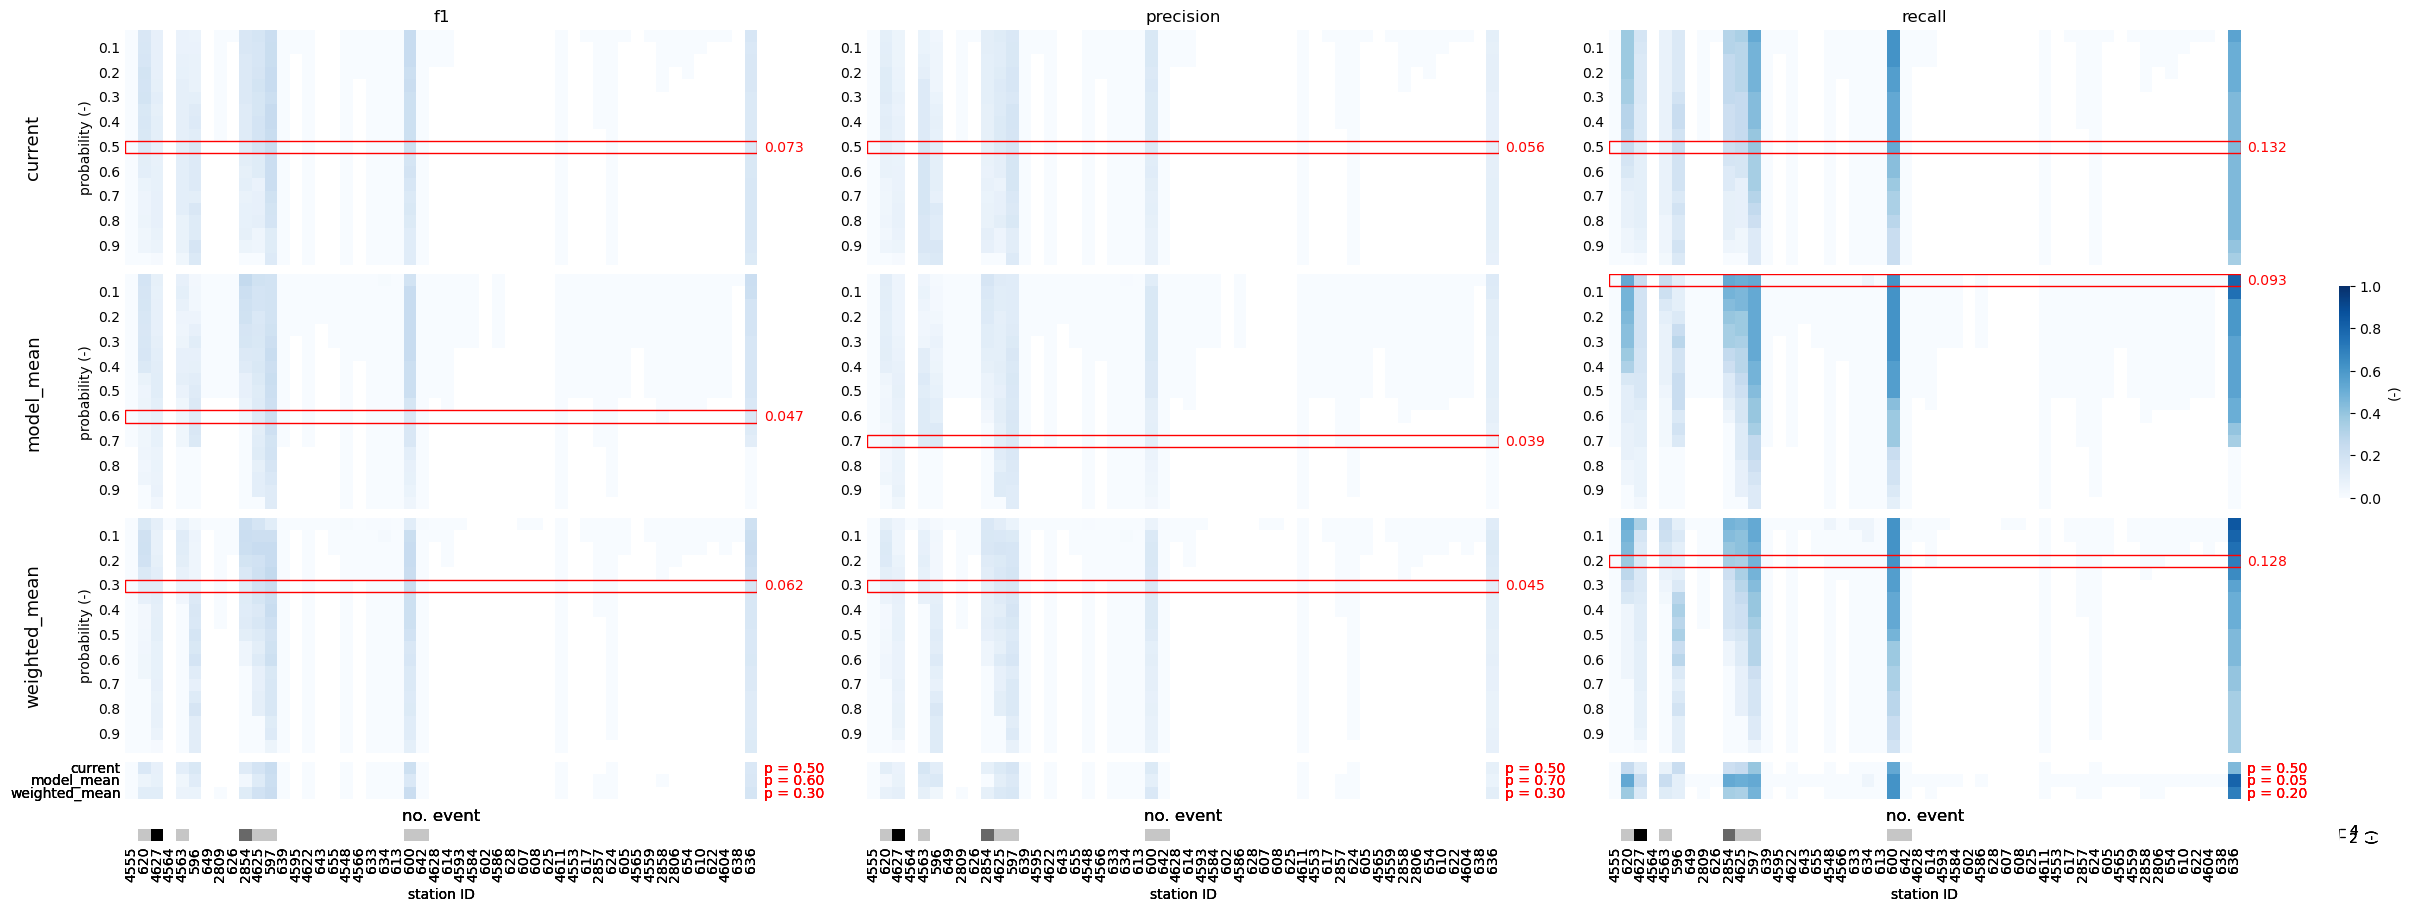

In [15]:
# plot results
for w in results2.window.data:
    plot_skill(results2.sel(window=w), rean_events.sum())

Conclusions from the previous plot:

* The skill scores are clearly lower when we look at the onset of the flood than when we look at the complete forecast (previous section). If in the latter we reached average scores up to 0.34, in the former we only reach values around 0.1.
* As it was expected, the skill increases as we widen the forecast window. This fact applies to all metrics, but it is specially noticeable in the `recall`.
* The same 9 stations that were identified in the previous section are those with higher scores in this analysis.
* `recall` values are clearly higher than `precision`. This means that the model finds observed events ("high" recall), but it predicts too many false alarms (low precision). That's the reason why the probability thresholds are much higher when optimizing precision instead of recall; to minimize the amount of false positives, the probability threshold is raised.

***

In [ ]:
# # number of timesteps surrounding the actual event
# windows = np.arange(0, 5).astype(int)

# # Dataset where results will be saved
# results = xr.Dataset(coords={'model': models,
#                              'probability': probabilities,
#                              'window': windows})

# for i, stn in enumerate(stations.index):  
    
#     print(f'Station {stn:>4d} ({i+1:>4d} of {n_stations:>4d})', end='\r')
    
#     # array where station results will be saved temporarily
#     results_station = np.zeros((len(results.model), len(results.probability), len(results.window))) * np.nan
    
#     for j, p in enumerate(probabilities):
        
#         # PERFORMANCE
#         # -----------
#         for k, w in enumerate(windows):
#             # compute f1 score and add values to the station table
#             obs = obs_events.sel(id=stn)
#             pred = pred_events.sel(id=stn, probability=p).to_dataset(dim='model').drop_vars('probability')
#             f1 = compute_f1(obs, pred, window=w)
#             results_station[:, j, k] = f1.max(axis=1).values
    
#     results[stn] = xr.DataArray(results_station, coords=results.coords)

# # merge all variables in a new dimension
# da_list = [results[stn].expand_dims('id', axis=0).assign_coords(id=[stn]).rename('f1') for stn in list(results)]
# results = xr.merge(da_list)['f1']

Revise this procedure (inclunding function `compute_f1`) to avoid the `for` loop along the probabilities.

In [ ]:
# nrows = len(results.model)
# fig, axes = plt.subplots(nrows=nrows, figsize=(7, 10), sharex=True, sharey=True)

# results_mean = results.mean('id')
# vmax = np.ceil(results_mean.max() / .05) * .05
# for i, (ax, model) in enumerate(zip(axes, results.model.data)):

#     da = results_mean.sel(model=model).transpose()
#     sns.heatmap(da, mask=da == 0, cmap='Blues', vmin=0, vmax=vmax, ax=ax,
#                 cbar_kws={'label': 'f1 (-)', 'shrink': .66})
    
#     if i + 1 == nrows:
#         ax.set_xlabel('probability (-)')
#     ax.set_xticklabels(results.probability.data)
#     ax.set_yticklabels([x * 6 for x in results.window.data])
#     ax.set_ylabel('window (h)')
    
#     ax.set_title(model)

* The graph above shows that the mean performance is poor when leadtime is disregarded. 
* The performance is extremely poor when predicting the exact timestep of the onset of the flood; this performace improves monotonically as we increase the time window accepted as a correct prediction. 
* Regarding the probability threshold, the highest performance depends on the model, but it is always lower than the current value of 30 %. It is around 10 and 15 %.

### 3.3 

In [16]:
# number of timesteps surrounding the actual event
windows = [1, 3, 5]

# Dataset where results will be saved
aux = xr.DataArray(dims=['id', 'model', 'leadtime', 'probability', 'window'], 
                   coords={'id': pred_events.id, 'model': pred_events.model, 'leadtime': pred_events.leadtime, 'probability': pred_events.probability, 'window': windows})
results3 = xr.Dataset({metric: aux.copy() for metric in metrics})

In [17]:
for i, stn in enumerate(results3.id.data):
    
    # extract observed and predicted events
    obs = obs_events.sel(id=stn)
    
    for w in results3.window.data:
        
        # compute predicted events according to the rolling sum
        mp = int(w / 2) + 1
        pred_w = pred_events.rolling({'leadtime': w}, center=True, min_periods=mp).sum() > 0
    
        for model in results3.model.data:
            for p in results3.probability.data:
                
                print('Station {0:>4d} ({1:>3d} of {2:>3d}) - window {5} - {3:<13} - probability {4:.0f}%'.format(stn, i+1, len(results3.id), model, p * 100, w),
                      end='\r')
                
                for ld in results3.leadtime.data:
                    
                    # extract observed and predicted events
                    obs = obs_events.sel(id=stn, leadtime=ld)
                    loc = {'id': stn, 'model': model, 'leadtime': ld, 'probability': p}
                    pred = pred_w.sel(loc)
                    
                    # compute performance
                    if obs.any() | pred.any():
                    
                        for key, func in metrics.items():
                            loc = loc = {'id': stn, 'model': model, 'leadtime': ld, 'probability': p, 'window': w}
                            results3[key].loc[loc] = func(obs.data.flatten(), pred.data.flatten())


In [ ]:
results3.dims

In [ ]:
results2['probability']

In [19]:
results3['leadtime'] = (results3.leadtime / np.timedelta64(6, 'h')).astype(int)

In [20]:
results3['leadtime'] = (pred_events.leadtime / 3600e9).astype(int)

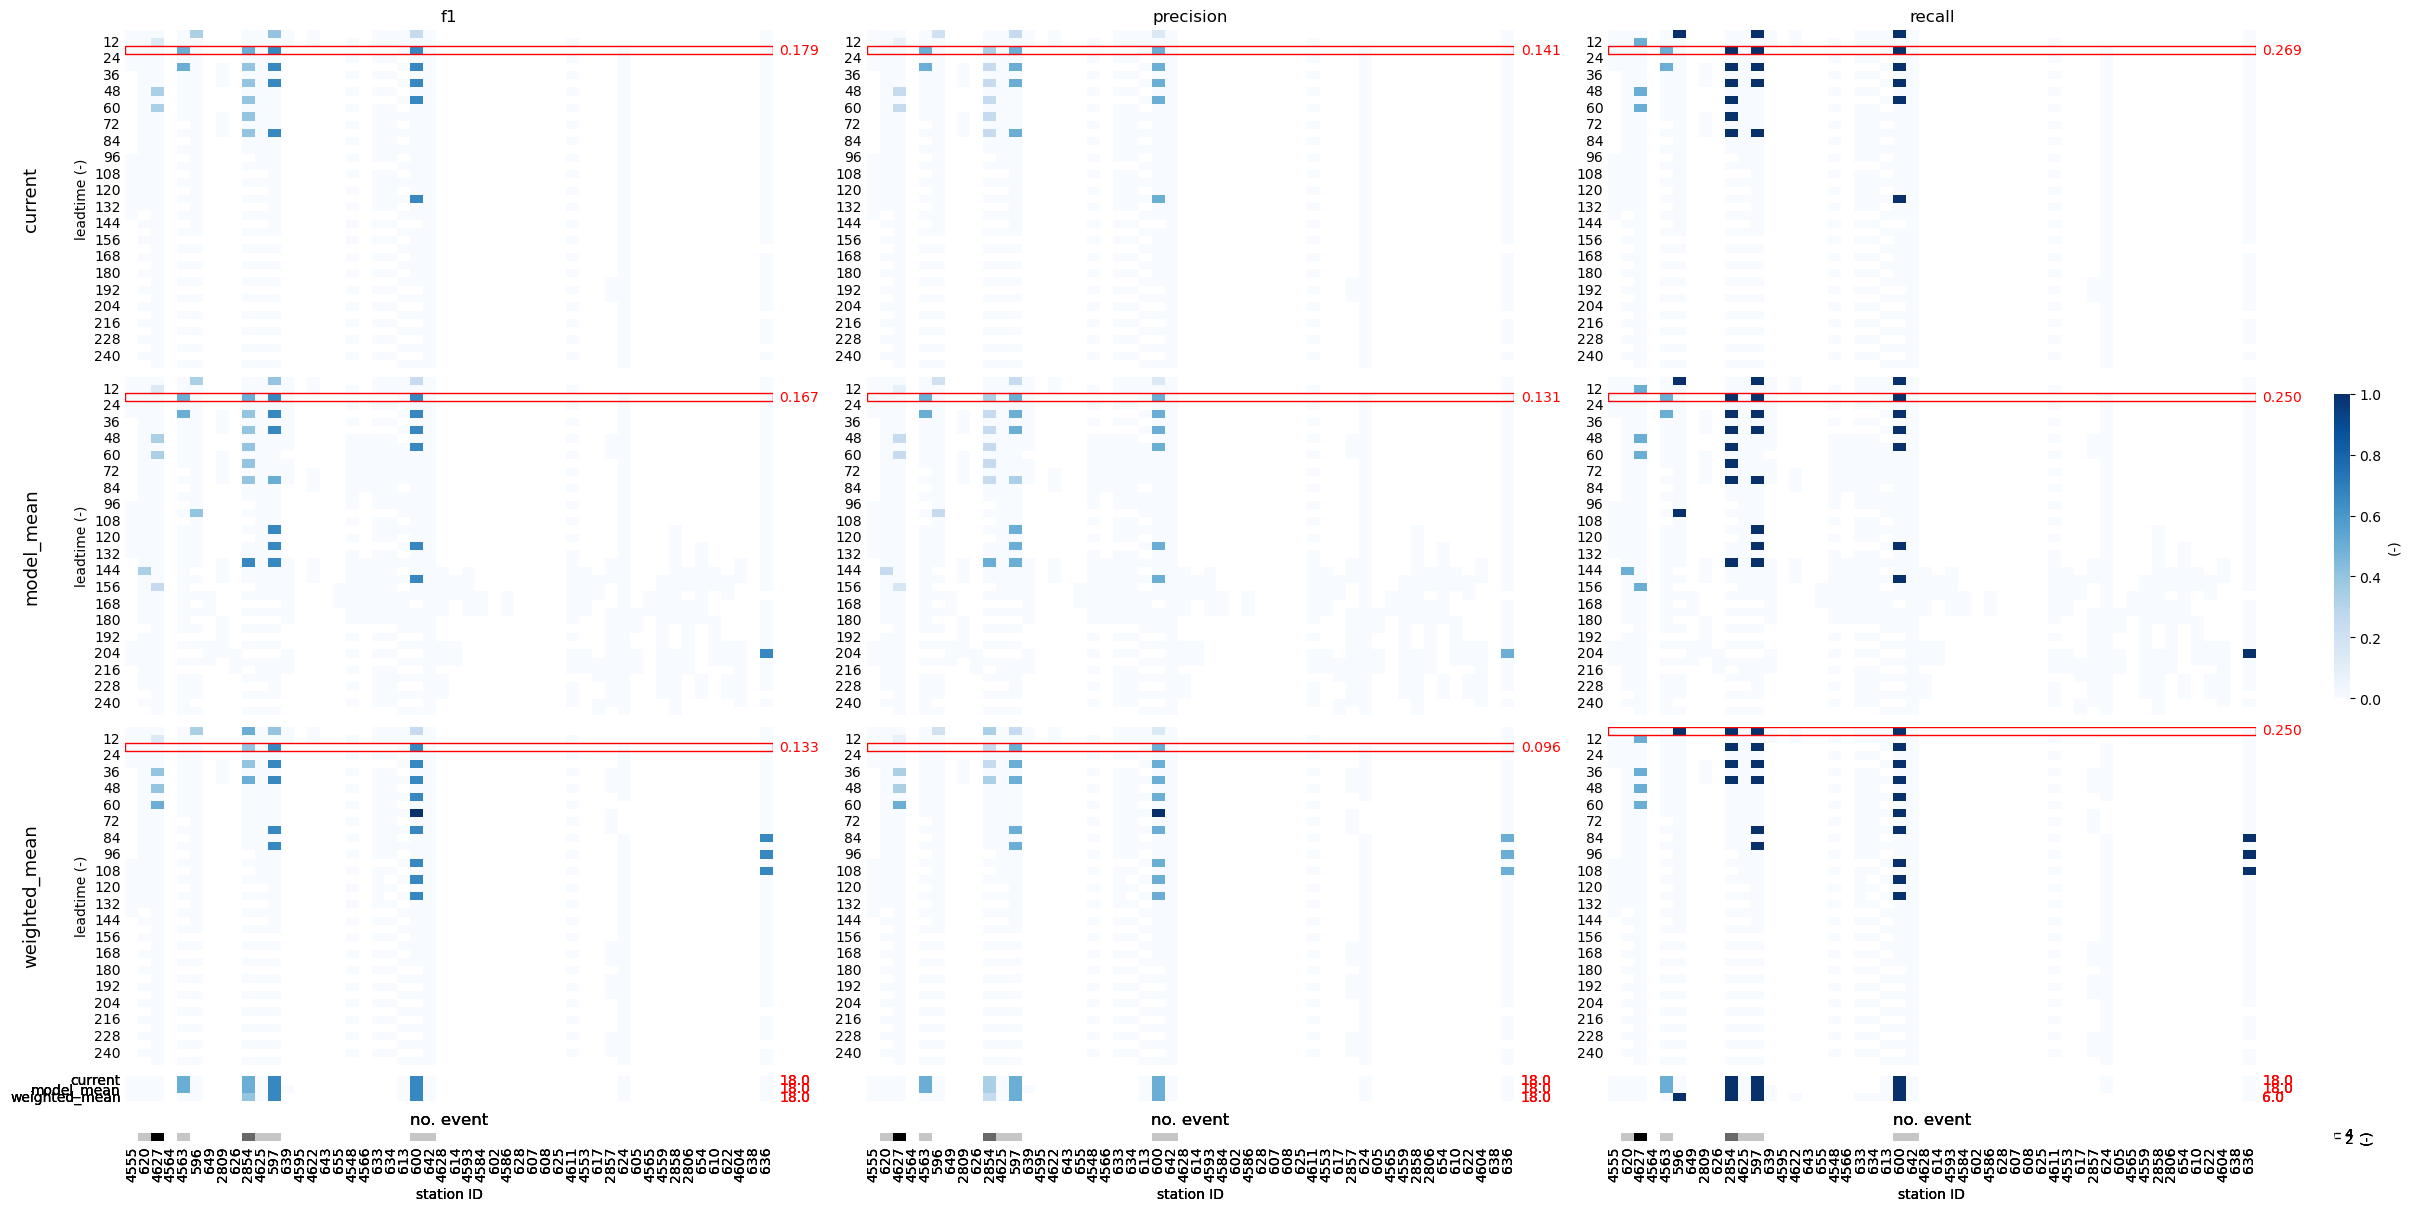

In [21]:
plot_skill(results3.sel(probability=.3, window=3), rean_events.sum(), xdim='id', ydim='leadtime', figsize=(24, 12))

In [ ]:
stn = 636

In [ ]:
obs = obs_events.sel(id=stn)
print(obs.dims)
print(obs.sum().data)

In [ ]:
pred = pred_w.sel({'id': stn, 'model': model, 'probability': p})
print(pred.dims)
print(pred.sum().data)

In [ ]:
TP = obs & pred
FP = pred & ~obs
FN = obs & ~pred

TP.sum().data, FP.sum().data, FN.sum().data

In [ ]:
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1 = 2 * recall * precision / (recall + precision)
print(f1.dims)
print(recall.mean().data, precision.mean().data, f1.mean().data)

In [ ]:
sns.heatmap(recall)

In [ ]:
                # compute performance
                if obs.any() | pred.any():
                    
                    for key, func in metrics.items():
                        loc = loc = {'id': stn, 'model': model, 'probability': p, 'window': w}
                        results2[key].loc[loc] = func(obs.data.flatten(), pred.data.flatten())

In [ ]:
plot_skill(results3.sel(window=5).mean('leadtime'), rean_events.sum())

***

### 3.4 

In [281]:
# number of timesteps surrounding the actual event
windows = [1, 3, 5]

var_agg = ['forecast']

tp, fn, fp, f1, recall, precision = {}, {}, {}, {}, {}, {}
for w in windows:
    # rolling sum of observations and predictions
    mp = int(w / 2) + 1
    obs_w = obs_events.rolling({'leadtime': w}, center=True, min_periods=mp).sum() > 0
    pred_w = pred.rolling({'leadtime': w}, center=True, min_periods=mp).sum() > 0
    
    # compute true positives and false negatives
    aux1 = pred_w.where(obs == 1)
    tp[w], fn[w] = (aux1 == 1).sum(var_agg), (aux1 == 0).sum(var_agg)
    
    # compute false positives
    aux2 = pred.where(obs_w == 0)
    fp[w] = (aux2 == 1).sum(var_agg)
    
    # compute scores
    recall[w] = tp[w] / (tp[w] + fn[w])
    precision[w] = tp[w] / (tp[w] + fp[w])
    f1[w] = 2 * tp[w] / (2 * tp[w] + fn[w] + fp[w])

results4 = xr.Dataset({'tp': xr.Dataset(tp).to_array(dim='window', name='tp'),
                       'fn': xr.Dataset(fn).to_array(dim='window', name='fn'),
                       'fp': xr.Dataset(fp).to_array(dim='window', name='fp'),
                       'f1': xr.Dataset(f1).to_array(dim='window', name='f1'),
                       'precision': xr.Dataset(precision).to_array(dim='window', name='precision'),
                       'recall': xr.Dataset(recall).to_array(dim='window', name='recall')})
results4['leadtime'] = (pred_events.leadtime / 3600e9).astype(int)

results4

<xarray.Dataset>
Dimensions:      (model: 3, leadtime: 41, probability: 19, id: 50, window: 3)
Coordinates:
  * model        (model) <U13 'current' 'model_mean' 'weighted_mean'
  * leadtime     (leadtime) int32 6 12 18 24 30 36 ... 216 222 228 234 240 246
  * probability  (probability) float64 0.05 0.1 0.15 0.2 ... 0.8 0.85 0.9 0.95
  * id           (id) int32 4555 620 4627 4564 4563 596 ... 610 622 4604 638 636
  * window       (window) int32 1 3 5
Data variables:
    tp           (window, id, model, leadtime, probability) int32 0 0 0 ... 0 0
    fn           (window, id, model, leadtime, probability) int32 0 0 0 ... 0 0
    fp           (window, id, model, leadtime, probability) int32 0 0 0 ... 0 0
    f1           (window, id, model, leadtime, probability) float64 nan ... nan
    precision    (window, id, model, leadtime, probability) float64 nan ... nan
    recall       (window, id, model, leadtime, probability) float64 nan ... nan

ID: 4627
model: current
probability: 0.30
window: 5

f1 = 0.196
precision = 0.310
recall = 0.143


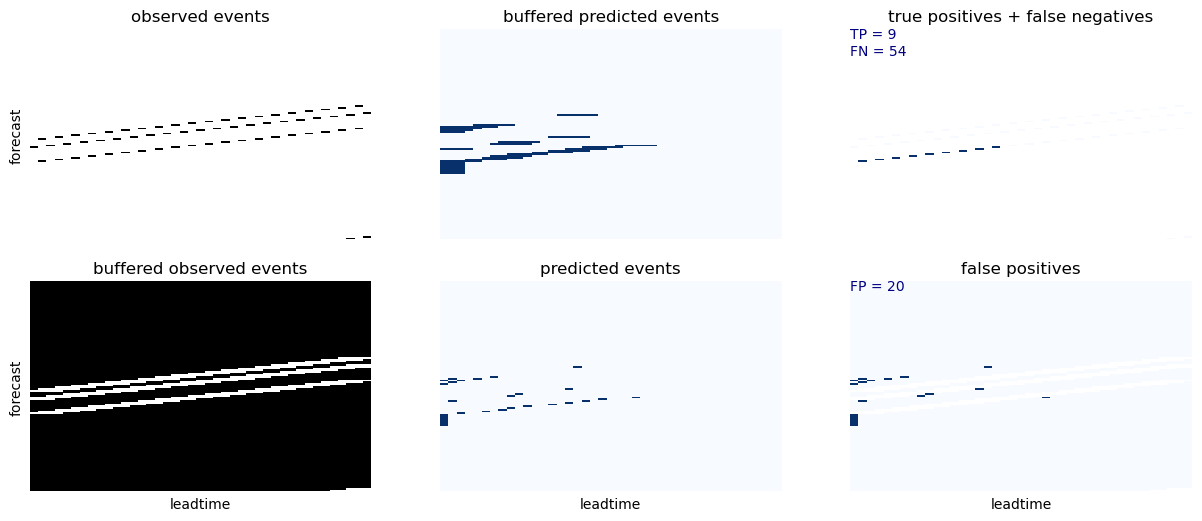

In [282]:
stn = 4627
forecast = slice(datetime(2021, 11, 1), None)
model = 'current'
p = .3

print(f'ID: {stn}\nmodel: {model}\nprobability: {p:.2f}\nwindow: {w}\n')

fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 6))

for axes in ax.flatten():
    axes.tick_params(length=0)
    
sns.heatmap(obs_events.sel(id=stn, forecast=forecast), cmap='Greys', cbar=False, ax=ax[0,0])
ax[0,0].set(title='observed events', ylabel='forecast')

sns.heatmap(obs_w.sel(id=stn, forecast=forecast), cmap='Greys_r', cbar=False, ax=ax[1,0])
ax[1,0].set(title='buffered observed events', xlabel='leadtime', yticks=[], ylabel='forecast')

sns.heatmap(pred_events.sel(id=stn, model=model, forecast=forecast, probability=p), cmap='Blues', cbar=False, ax=ax[1,1])
ax[1,1].set(title='predicted events', xlabel='leadtime')

sns.heatmap(pred_w.sel(id=stn, model=model, forecast=forecast, probability=p), cmap='Blues', cbar=False, ax=ax[0,1])
ax[0,1].set(title='buffered predicted events')

sns.heatmap(aux1.sel(id=stn, model=model, forecast=forecast, probability=p), cmap='Blues', cbar=False, ax=ax[0,2])
ax[0,2].set(title='true positives + false negatives')
tp = TP.sel(id=stn, model=model, probability=p).sum().data
ax[0,2].text(0, 5, f'TP = {tp}', color='navy')
fn = FN.sel(id=stn, model=model, probability=p).sum().data
ax[0,2].text(0, 15, f'FN = {fn}', color='navy')

sns.heatmap(aux2.sel(id=stn, model=model, forecast=forecast, probability=p), cmap='Blues', cbar=False, ax=ax[1,2])
ax[1,2].set(title='false positives', xlabel='leadtime', xticks=[], yticks=[])
fp = FP.sel(id=stn, model=model, probability=p).sum().data
ax[1,2].text(0, 5, f'FP = {fp}', color='navy')


print('f1 = {0:.3f}'.format(2 * tp / (2 * tp + fn + fp)))
print('precision = {0:.3f}'.format(tp / (tp + fp)))
print('recall = {0:.3f}'.format(tp / (tp + fn)))

**Checks**

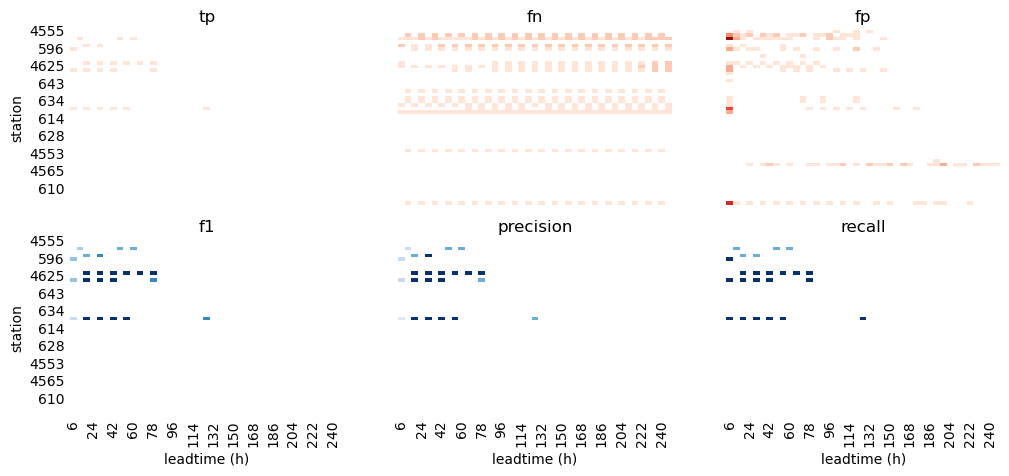

In [379]:
m = 'current'
p = .3
w = 3

ds_stn = results4.sel(model=m, probability=p, window=w)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharex=True, sharey=True)

for i, (var, da) in enumerate(ds_stn.items()):
    
    r, c = int(i / 3), i % 3
    ax = axes[r,c]
    
    if r == 0:
        vmax = 10
        cmap = 'Reds'
    else:
        vmax = 1
        cmap = 'Blues'
        
    
    sns.heatmap(da, mask=da == 0, cmap=cmap, vmin=0, vmax=vmax, ax=ax,
                cbar=False, cbar_kws={'shrink': .9})
    ax.set_title(var)
    # ax.set(xlabel='leadtime', ylabel='station', title=var)
    ax.set_yticklabels(da['id'].data[::5])
    ax.set_xticklabels(da['leadtime'].data[::3], rotation=90)
    ax.tick_params(length=0)
    if c == 0:
        ax.set(ylabel='station')
        
    if r == 1:
        ax.set(xlabel='leadtime (h)')

In [400]:
ds_stn['tp'].sel(id=[620, 4627, 4563, 2854], leadtime=slice(0, 72))

<xarray.DataArray 'tp' (id: 4, leadtime: 12)>
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]])
Coordinates:
    model        <U13 'current'
  * leadtime     (leadtime) int32 6 12 18 24 30 36 42 48 54 60 66 72
    probability  float64 0.3
  * id           (id) int32 620 4627 4563 2854
    window       int32 3

In [402]:
ds_stn['fp'].sel(id=[620, 4627, 4563, 2854], leadtime=slice(0, 72))

<xarray.DataArray 'fp' (id: 4, leadtime: 12)>
array([[4, 2, 1, 2, 0, 2, 1, 2, 0, 1, 1, 2],
       [9, 3, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]])
Coordinates:
    model        <U13 'current'
  * leadtime     (leadtime) int32 6 12 18 24 30 36 42 48 54 60 66 72
    probability  float64 0.3
  * id           (id) int32 620 4627 4563 2854
    window       int32 3

In [401]:
ds_stn['fn'].sel(id=[620, 4627, 4563, 2854], leadtime=slice(0, 72))

<xarray.DataArray 'fn' (id: 4, leadtime: 12)>
array([[0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2],
       [1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2],
       [2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 2, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Coordinates:
    model        <U13 'current'
  * leadtime     (leadtime) int32 6 12 18 24 30 36 42 48 54 60 66 72
    probability  float64 0.3
  * id           (id) int32 620 4627 4563 2854
    window       int32 3

In [405]:
da_id.sel(id=[620, 4627, 4563, 2854])

<xarray.DataArray (metric: 3, id: 4)>
array([[0.        , 0.06521739, 0.08510638, 0.32432432],
       [0.        , 0.04761905, 0.04761905, 0.26086957],
       [0.        , 0.10344828, 0.4       , 0.42857143]])
Coordinates:
    model        <U13 'current'
    probability  float64 0.3
  * id           (id) int32 620 4627 4563 2854
    window       int32 3
  * metric       (metric) <U9 'f1' 'precision' 'recall'

**Skill depending on leadtime**<br>
By summing up hits and falses across stations.

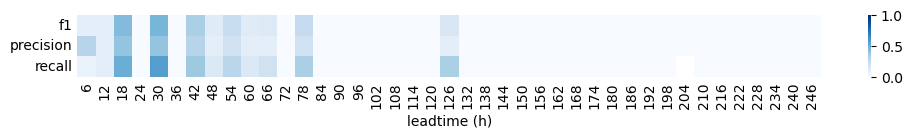

In [390]:
# add positives and negatives across stations
TP, FN, FP = ds_stn['tp'].sum('id'), ds_stn['fn'].sum('id'), ds_stn['fp'].sum('id')

# compute skill metrics
da_lt = xr.Dataset({'f1': 2 * TP / (2 * TP + FN + FP),
                 'precision': TP / (TP + FN),
                 'recall': TP / (TP + FP)}).to_array(dim='metric')

fig, ax = plt.subplots(figsize=(12,.8))
sns.heatmap(da_lt, cmap='Blues', ax=ax, vmin=0, vmax=1)
ax.set_xticklabels(da_lt.leadtime.data, rotation=90)
ax.set_yticklabels(da_lt.metric.data, rotation=0)
ax.tick_params(length=0)
ax.set(xlabel='leadtime (h)');

**Station skill**<br>
By summing up the hits and falses across leadtime.

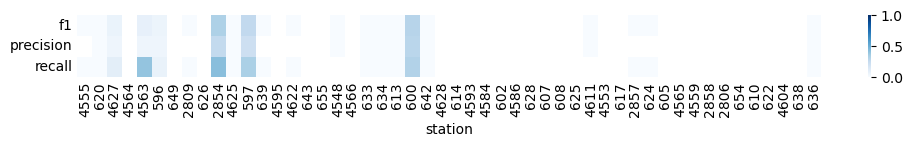

In [391]:
# add positives and negatives across leadtime
TP, FN, FP = ds_stn['tp'].sum('leadtime'), ds_stn['fn'].sum('leadtime'), ds_stn['fp'].sum('leadtime')

# compute skill metrics
da_id = xr.Dataset({'f1': 2 * TP / (2 * TP + FN + FP),
                 'precision': TP / (TP + FN),
                 'recall': TP / (TP + FP)}).to_array(dim='metric')

fig, ax = plt.subplots(figsize=(12, .8))
sns.heatmap(da_id, cmap='Blues', ax=ax, vmin=0, vmax=1)
ax.set_xticklabels(da_id.id.data, rotation=90)
ax.set_yticklabels(da_id.metric.data, rotation=0)
ax.tick_params(length=0)
ax.set(xlabel='station');

In [397]:
results4.dims

Frozen({'model': 3, 'leadtime': 41, 'probability': 19, 'id': 50, 'window': 3})

In [396]:
results4['f1'].sel(id=stn, model=m, probability=p, window=w)

<xarray.DataArray 'f1' (leadtime: 41)>
array([0.        , 0.33333333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.5       , 0.        , 0.5       ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])
Coordinates:
    model        <U13 'current'
  * leadtime     (leadtime) int32 6 12 18 24 30 36 ... 216 222 228 234 240 246
    probability  float64 0.3
    id           int32 4627
    window       int32 3

In [388]:
ds_stn['tp'].sel(id=stn)

<xarray.DataArray 'tp' (leadtime: 41)>
array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
    model        <U13 'current'
  * leadtime     (leadtime) int32 6 12 18 24 30 36 ... 216 222 228 234 240 246
    probability  float64 0.3
    id           int32 4627
    window       int32 3

#### 3.4.1 Depending on leadtime

Fixed probability and window.

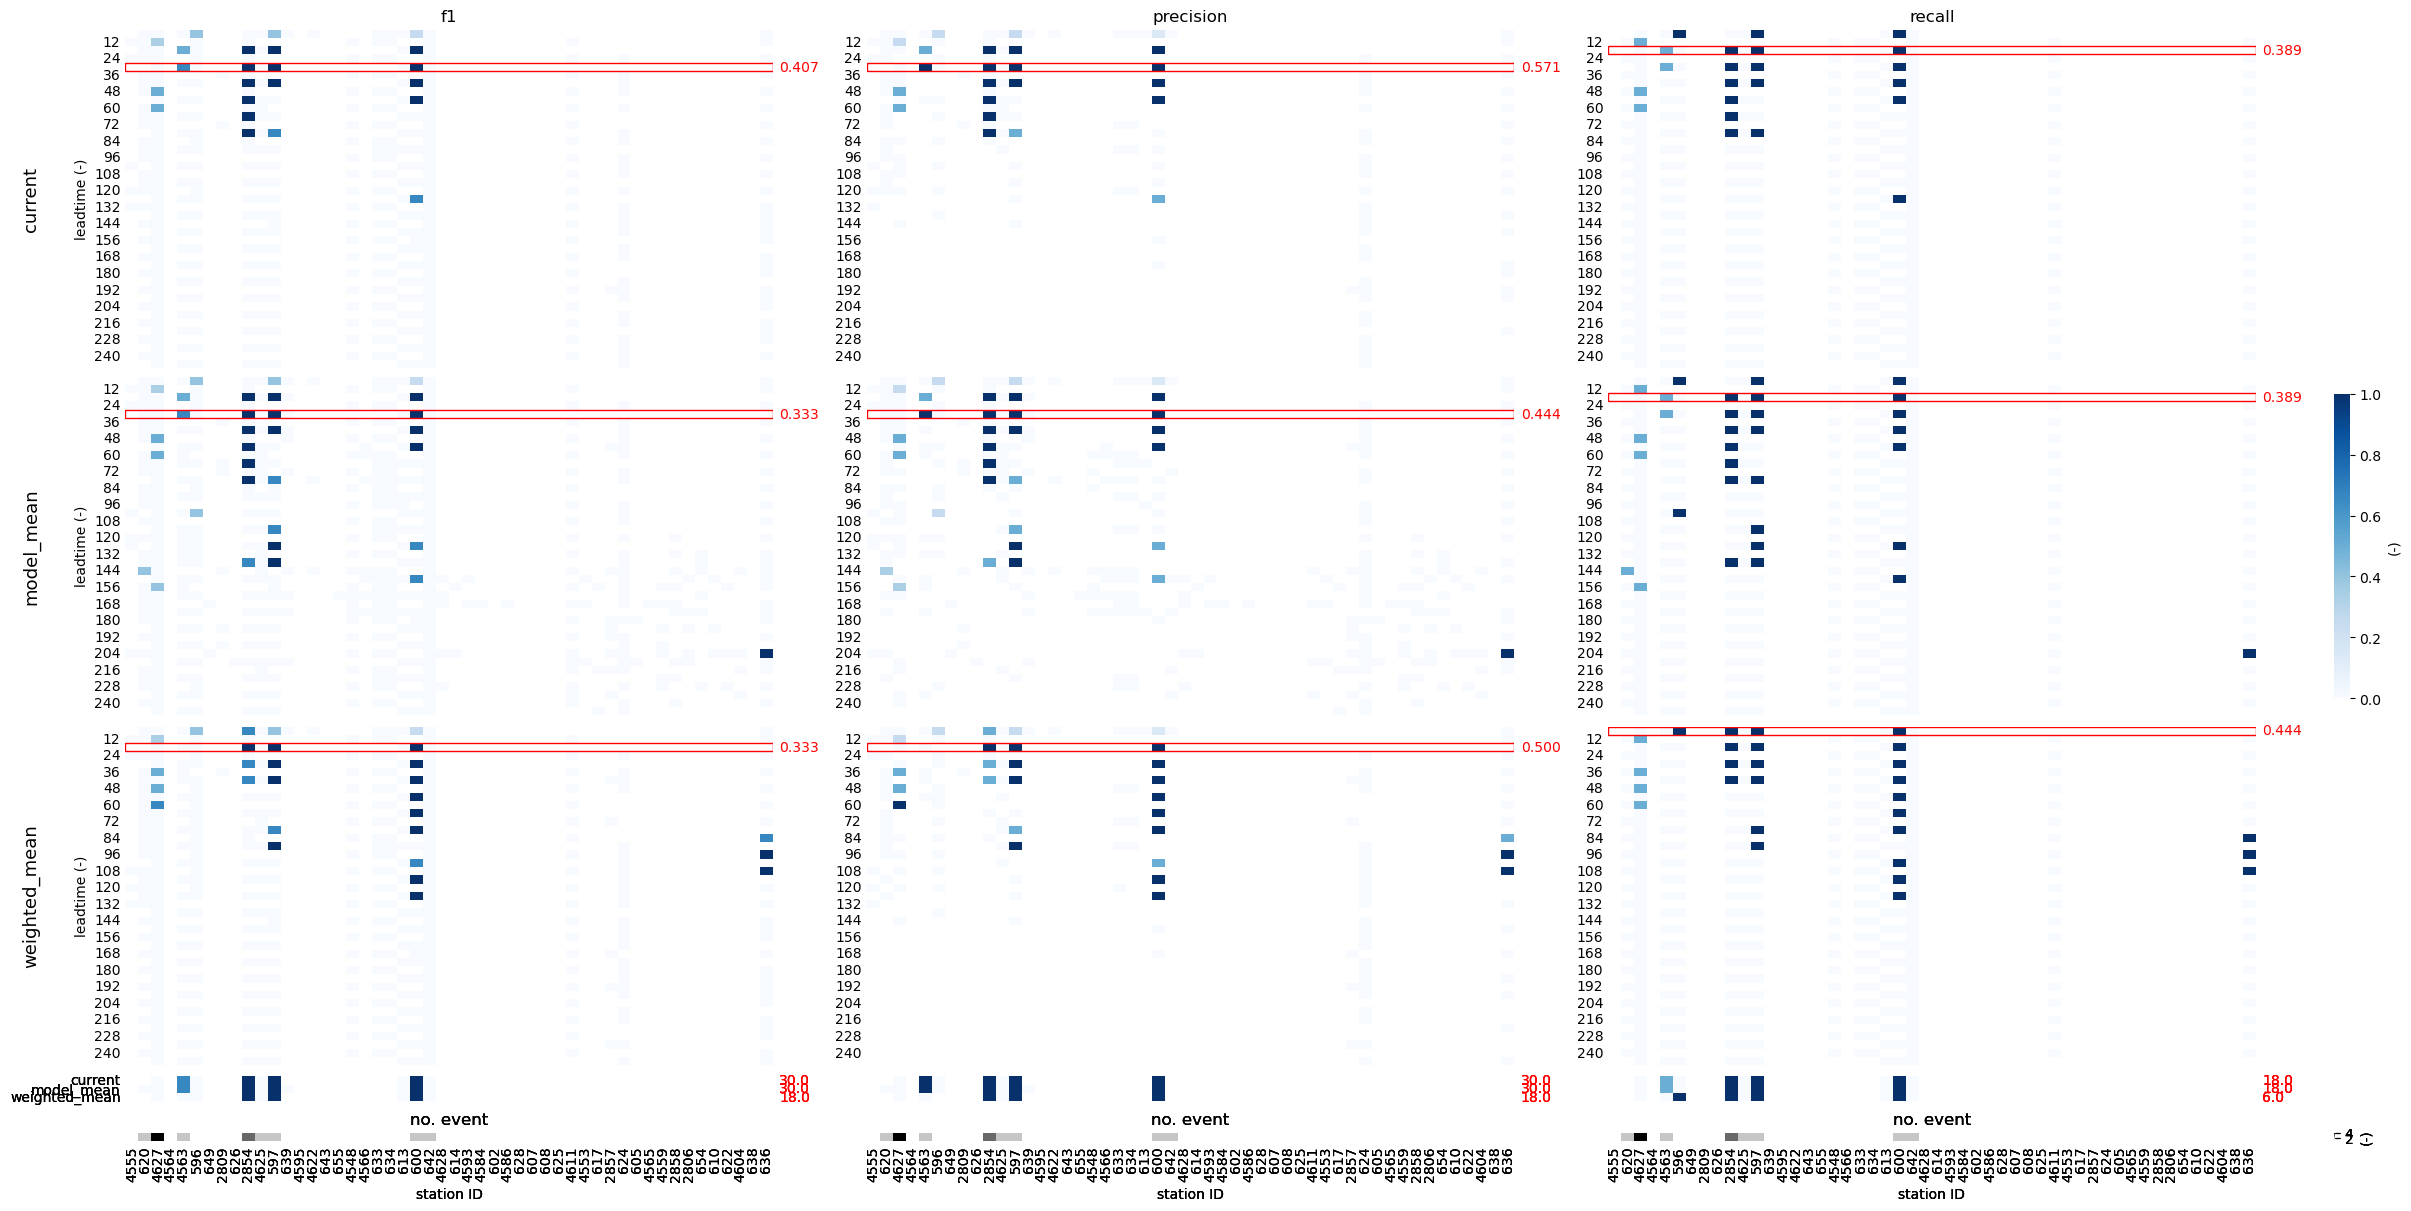

In [217]:
w = 3
p = .3

plot_skill(results4.sel(probability=p, window=w), rean_events.sum(), xdim='id', ydim='leadtime', figsize=(24, 12))

#### 3.4.2 Depending on probability

Fixed window and mean across leadtime.

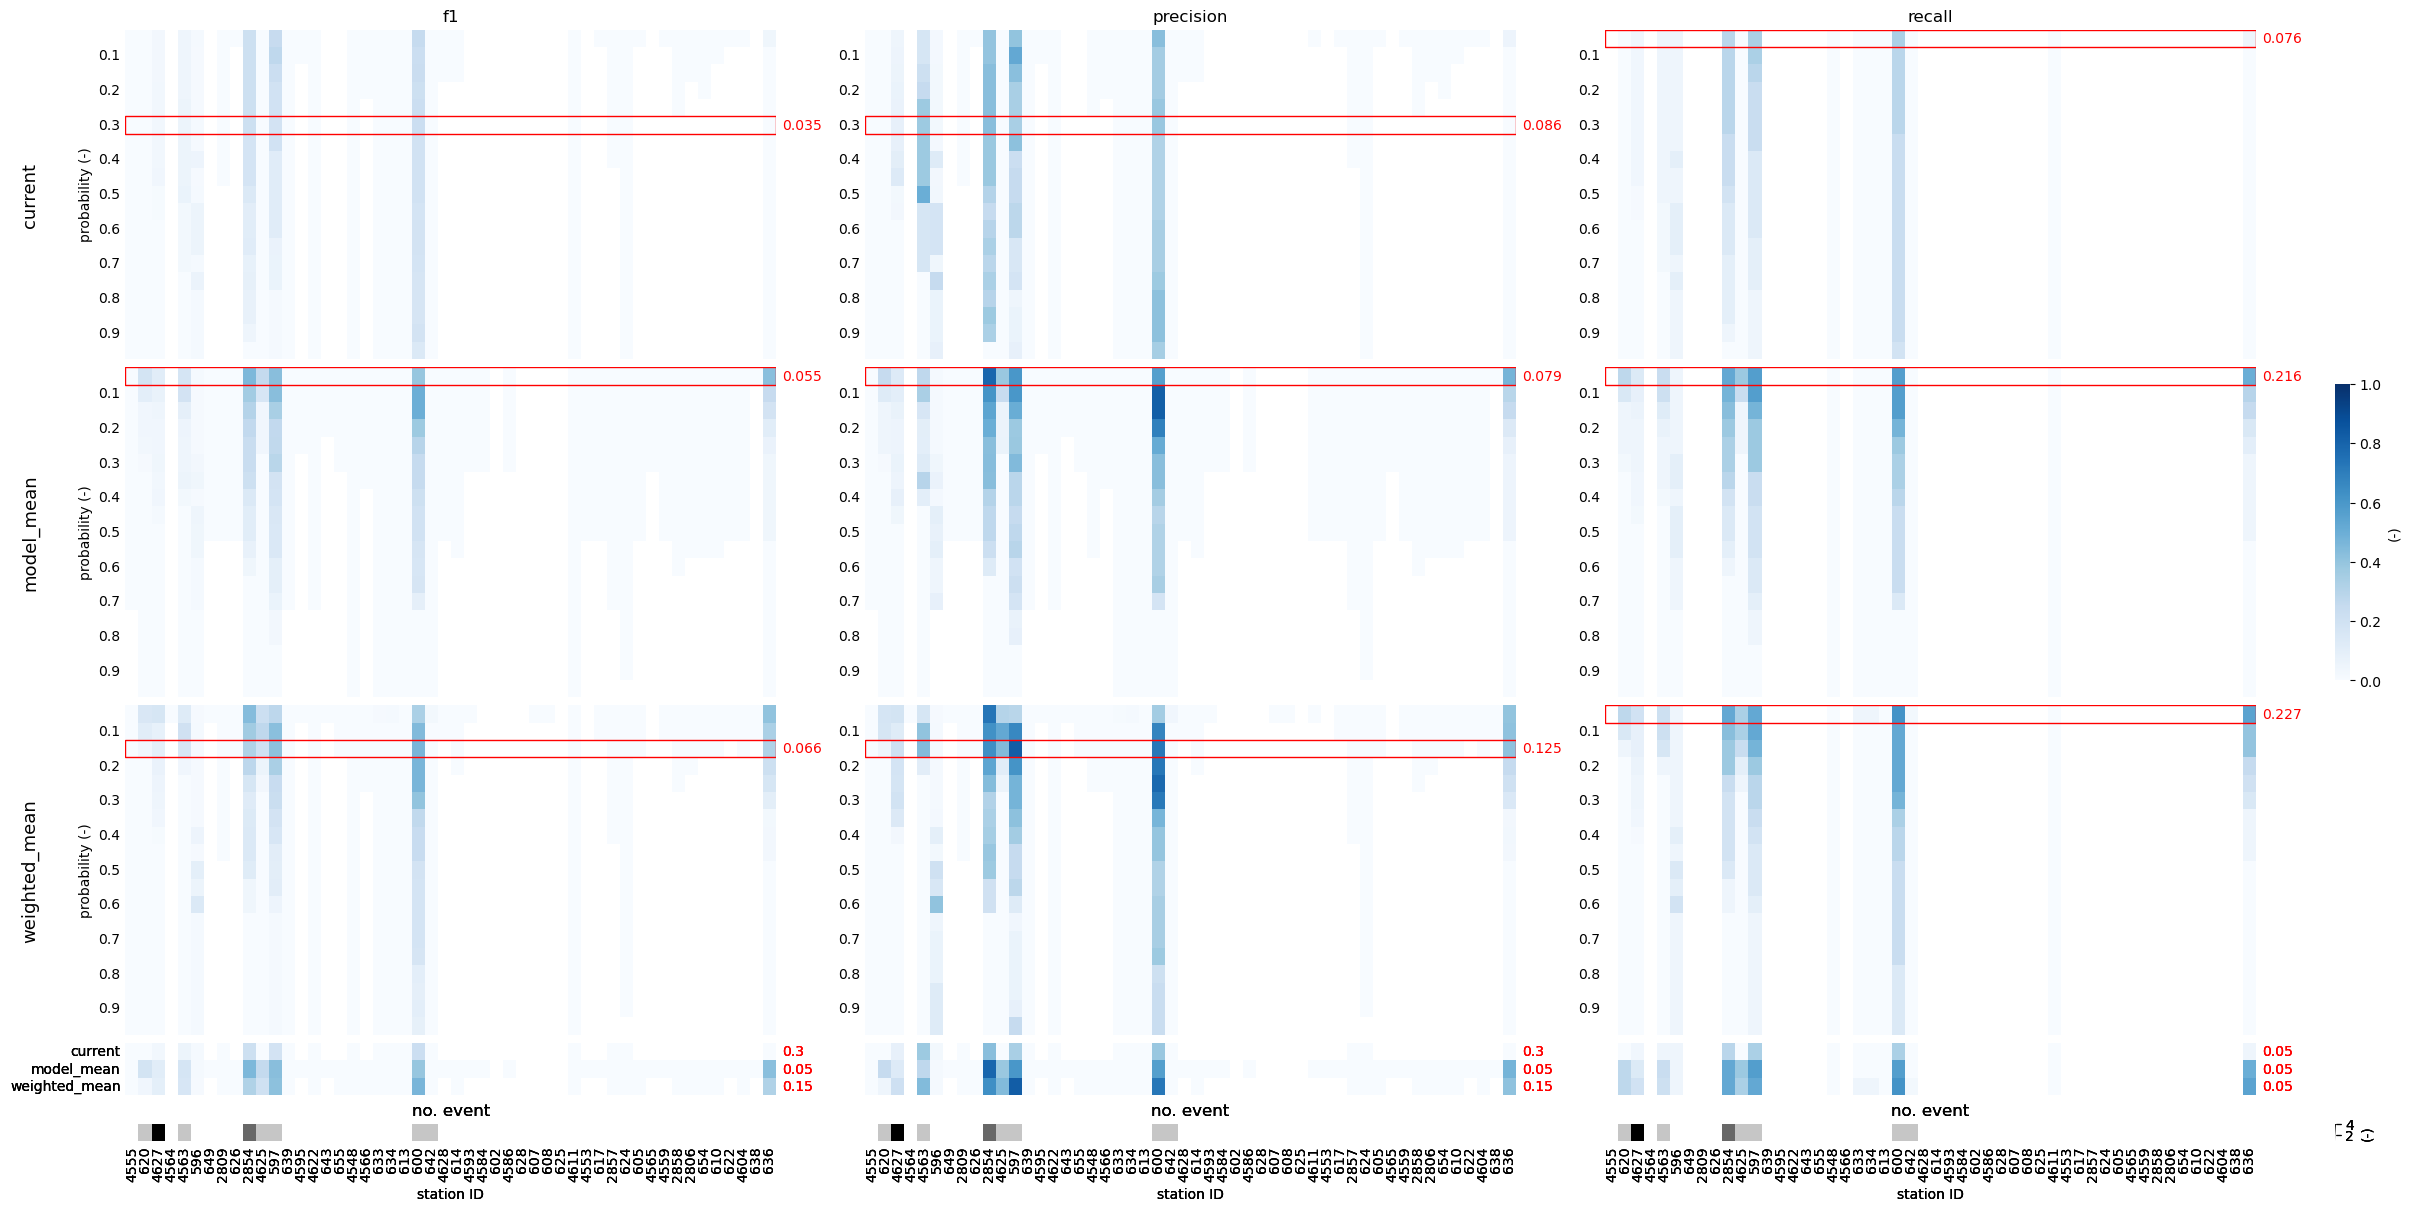

In [221]:
w = 3

plot_skill(results4.sel(window=w).mean('leadtime'), rean_events.sum(), xdim='id', ydim='probability', figsize=(24, 12))

#### 3.4.3 Depending on probability and leadtime

Fixed window and mean across stations.

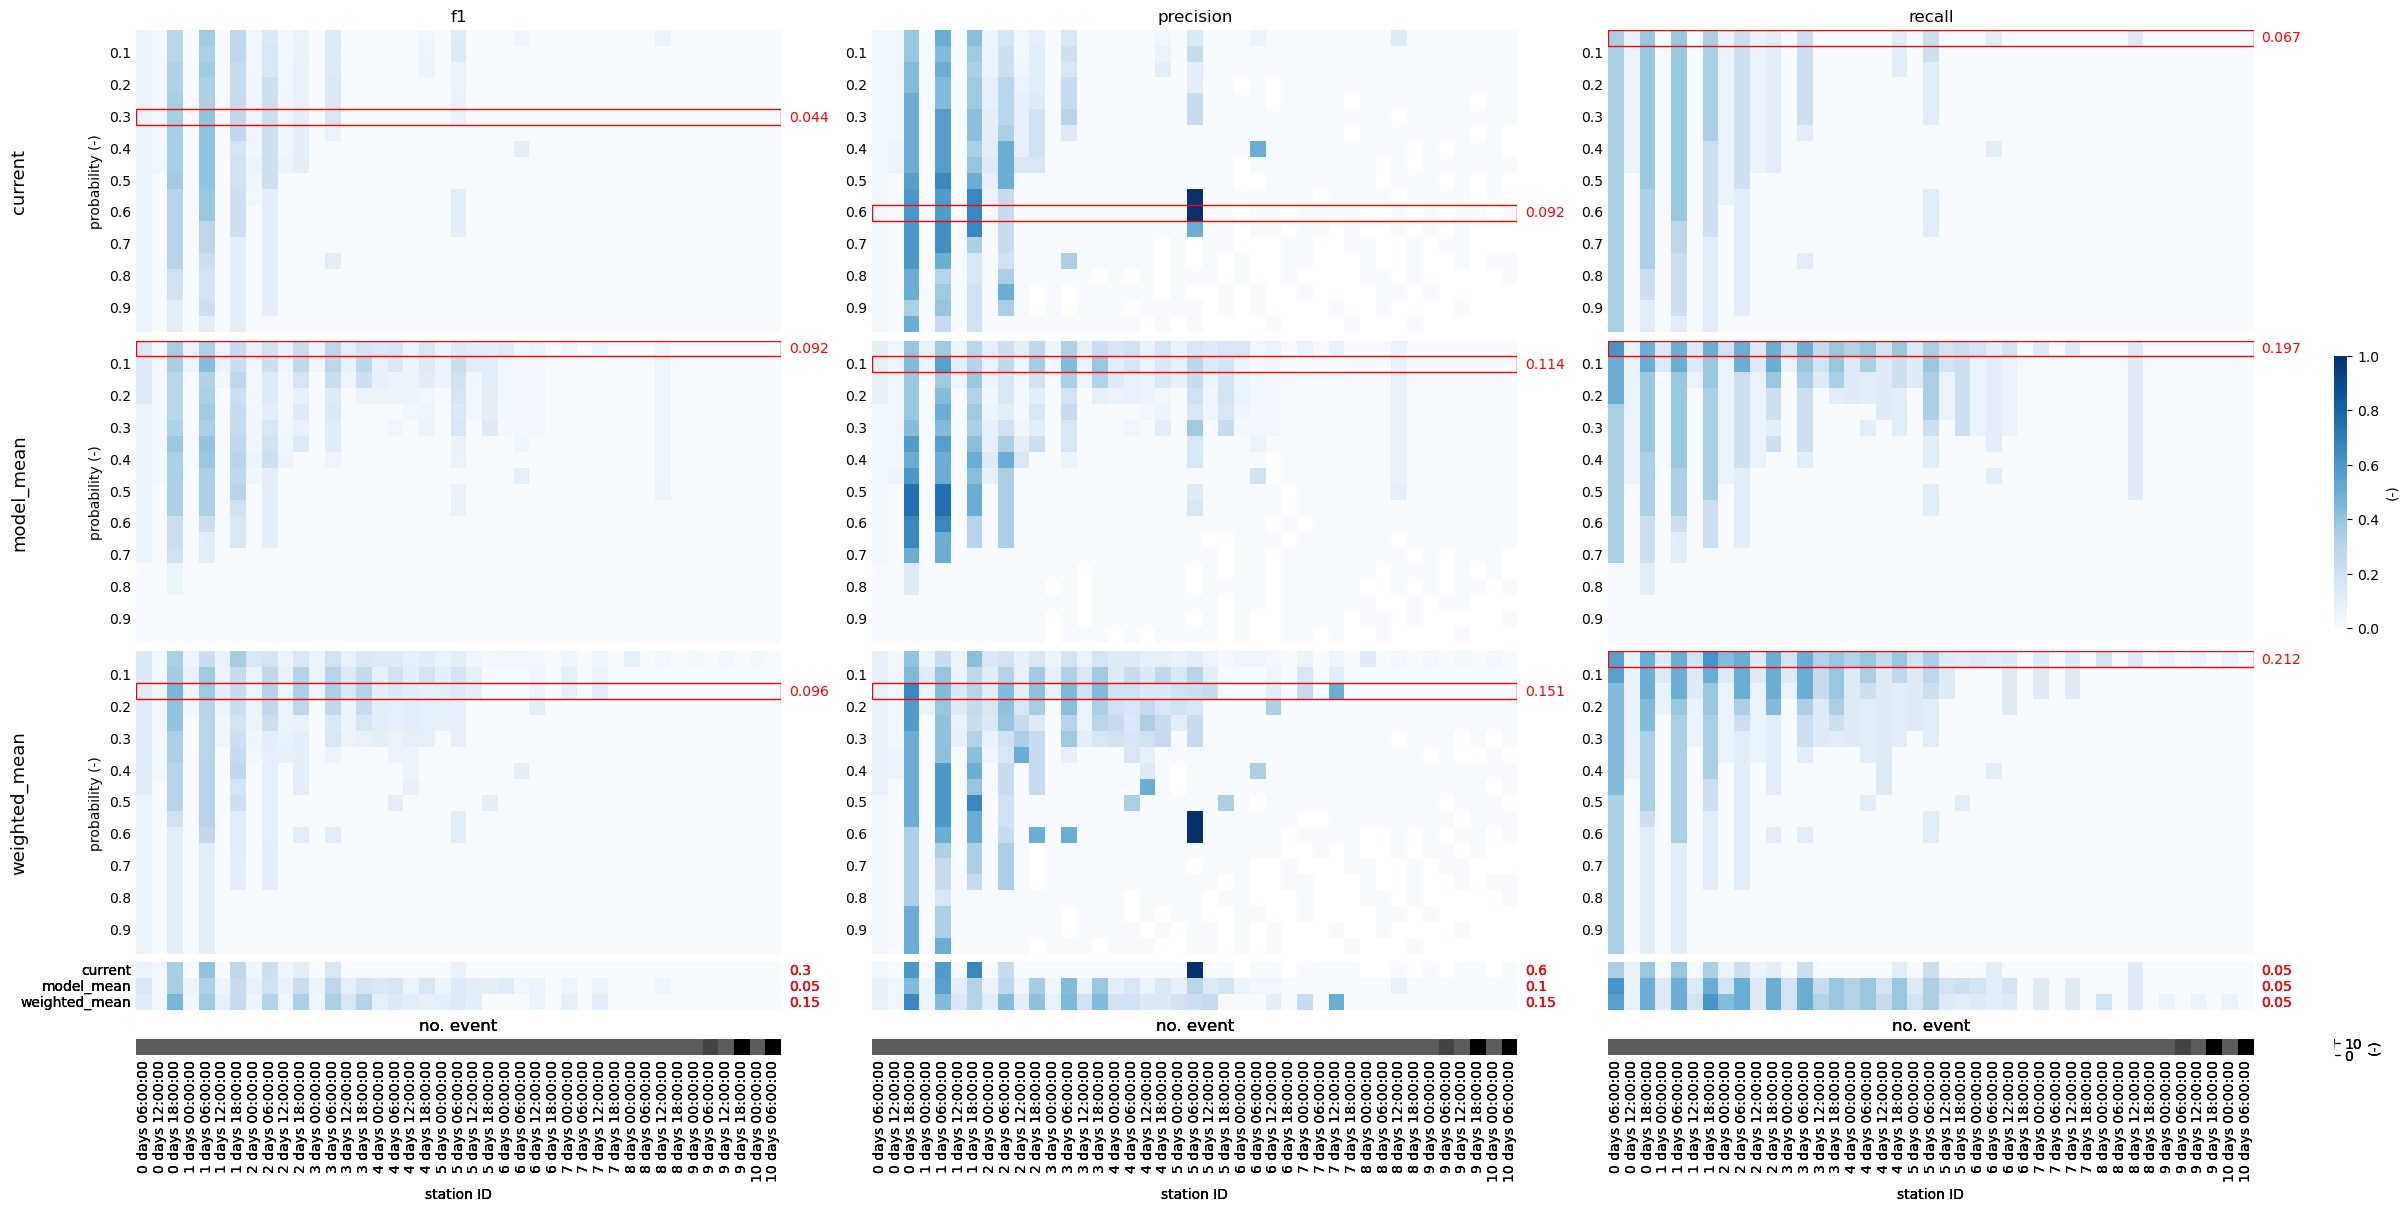

In [307]:
w = 3

plot_skill(results4[['f1', 'precision', 'recall']].sel(window=w).mean('id'),
           obs_events.sum(['forecast', 'id']).to_pandas(),
           xdim='leadtime', ydim='probability', figsize=(24, 12))

***

### 3.5 12-hourly resampled

In [406]:
# resample data daily
resample_dict = {'leadtime': '12h'}
obs_events_12h = obs_events.resample(resample_dict).any()
pred_events_12h = pred_events.resample(resample_dict).any()

In [417]:
# number of timesteps surrounding the actual event
windows = [1, 3]

var_agg = ['forecast']

tp, fn, fp, f1, recall, precision = {}, {}, {}, {}, {}, {}
for w in windows:
    # rolling sum of observations and predictions
    mp = int(w / 2) + 1
    obs_w = obs_events_12h.rolling({'leadtime': w}, center=True, min_periods=mp).sum() > 0
    pred_w = pred_events_12h.rolling({'leadtime': w}, center=True, min_periods=mp).sum() > 0
    
    # compute true positives and false negatives
    aux1 = pred_w.where(obs == 1)
    tp[w], fn[w] = (aux1 == 1).sum(var_agg), (aux1 == 0).sum(var_agg)
    
    # compute false positives
    aux2 = pred.where(obs_w == 0)
    fp[w] = (aux2 == 1).sum(var_agg)
    
    # compute scores
    recall[w] = tp[w] / (tp[w] + fn[w])
    precision[w] = tp[w] / (tp[w] + fp[w])
    f1[w] = 2 * tp[w] / (2 * tp[w] + fn[w] + fp[w])

results5 = xr.Dataset({'tp': xr.Dataset(tp).to_array(dim='window', name='tp'),
                       'fn': xr.Dataset(fn).to_array(dim='window', name='fn'),
                       'fp': xr.Dataset(fp).to_array(dim='window', name='fp'),
                       'f1': xr.Dataset(f1).to_array(dim='window', name='f1'),
                       'precision': xr.Dataset(precision).to_array(dim='window', name='precision'),
                       'recall': xr.Dataset(recall).to_array(dim='window', name='recall')})
results5['leadtime'] = (pred_events_12h.leadtime / 3600e9).astype(int)

results5

<xarray.Dataset>
Dimensions:      (leadtime: 21, model: 3, probability: 19, id: 50, window: 2)
Coordinates:
  * leadtime     (leadtime) int32 6 18 30 42 54 66 ... 186 198 210 222 234 246
  * model        (model) <U13 'current' 'model_mean' 'weighted_mean'
  * probability  (probability) float64 0.05 0.1 0.15 0.2 ... 0.8 0.85 0.9 0.95
  * id           (id) int32 4555 620 4627 4564 4563 596 ... 610 622 4604 638 636
  * window       (window) int32 1 3
Data variables:
    tp           (window, id, model, leadtime, probability) int32 0 0 0 ... 0 0
    fn           (window, id, model, leadtime, probability) int32 0 0 0 ... 0 0
    fp           (window, id, model, leadtime, probability) int32 0 0 0 ... 0 0
    f1           (window, id, model, leadtime, probability) float64 nan ... nan
    precision    (window, id, model, leadtime, probability) float64 nan ... nan
    recall       (window, id, model, leadtime, probability) float64 nan ... nan

ID: 4627
model: current
probability: 0.30
window: 3

f1 = 0.103
precision = 0.125
recall = 0.087


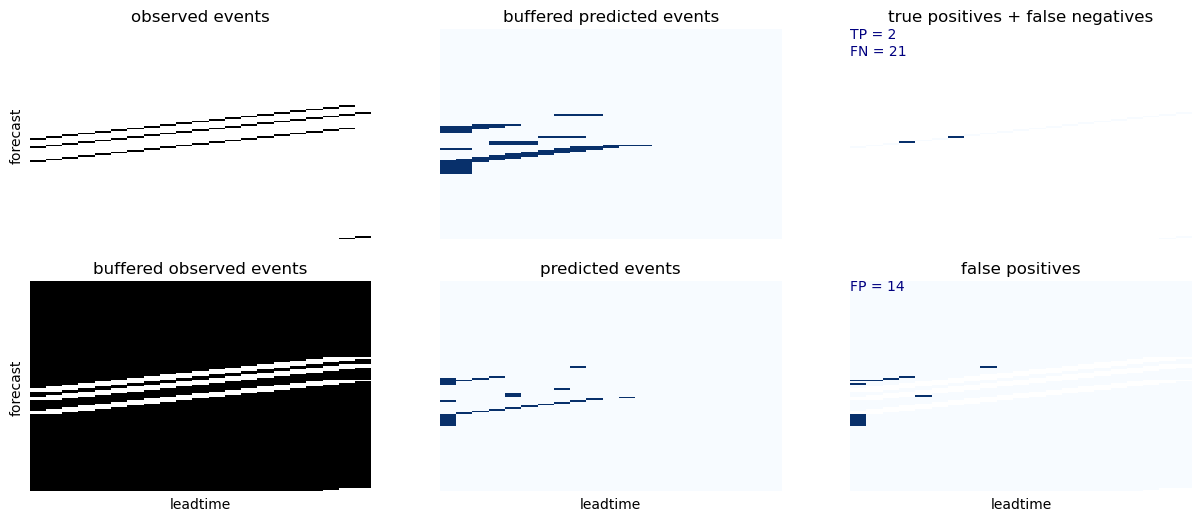

In [418]:
stn = 4627
forecast = slice(datetime(2021, 11, 1), None)
model = 'current'
p = .3

print(f'ID: {stn}\nmodel: {model}\nprobability: {p:.2f}\nwindow: {w}\n')

fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 6))

for axes in ax.flatten():
    axes.tick_params(length=0)
    
sns.heatmap(obs_events_12h.sel(id=stn, forecast=forecast), cmap='Greys', cbar=False, ax=ax[0,0])
ax[0,0].set(title='observed events', ylabel='forecast')

sns.heatmap(obs_w.sel(id=stn, forecast=forecast), cmap='Greys_r', cbar=False, ax=ax[1,0])
ax[1,0].set(title='buffered observed events', xlabel='leadtime', yticks=[], ylabel='forecast')

sns.heatmap(pred_events_12h.sel(id=stn, model=model, forecast=forecast, probability=p), cmap='Blues', cbar=False, ax=ax[1,1])
ax[1,1].set(title='predicted events', xlabel='leadtime')

sns.heatmap(pred_w.sel(id=stn, model=model, forecast=forecast, probability=p), cmap='Blues', cbar=False, ax=ax[0,1])
ax[0,1].set(title='buffered predicted events')

sns.heatmap(aux1.sel(id=stn, model=model, forecast=forecast, probability=p), cmap='Blues', cbar=False, ax=ax[0,2])
ax[0,2].set(title='true positives + false negatives')
tp_id = tp[w].sel(id=stn, model=model, probability=p).sum().data
ax[0,2].text(0, 5, f'TP = {tp_id}', color='navy')
fn_id = fn[w].sel(id=stn, model=model, probability=p).sum().data
ax[0,2].text(0, 15, f'FN = {fn_id}', color='navy')

sns.heatmap(aux2.sel(id=stn, model=model, forecast=forecast, probability=p), cmap='Blues', cbar=False, ax=ax[1,2])
ax[1,2].set(title='false positives', xlabel='leadtime', xticks=[], yticks=[])
fp_id = fp[w].sel(id=stn, model=model, probability=p).sum().data
ax[1,2].text(0, 5, f'FP = {fp_id}', color='navy')


print('f1 = {0:.3f}'.format(2 * tp_id / (2 * tp_id + fn_id + fp_id)))
print('precision = {0:.3f}'.format(tp_id / (tp_id + fp_id)))
print('recall = {0:.3f}'.format(tp_id / (tp_id + fn_id)))

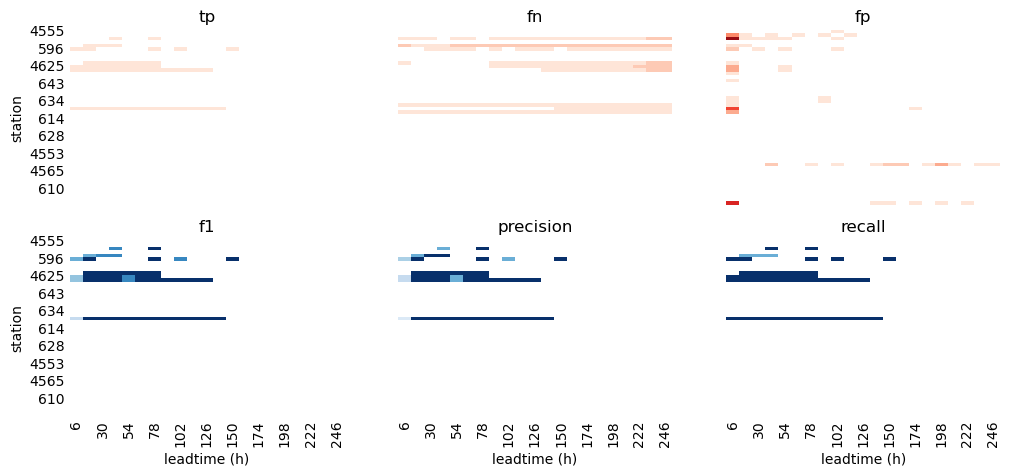

In [422]:
m = 'current'
p = .3
w = 3

ds_stn = results5.sel(model=m, probability=p, window=w)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharex=True, sharey=True)

for i, (var, da) in enumerate(ds_stn.items()):
    
    r, c = int(i / 3), i % 3
    ax = axes[r,c]
    
    if r == 0:
        vmax = 10
        cmap = 'Reds'
    else:
        vmax = 1
        cmap = 'Blues'
        
    
    sns.heatmap(da, mask=da == 0, cmap=cmap, vmin=0, vmax=vmax, ax=ax,
                cbar=False, cbar_kws={'shrink': .9})
    ax.set_title(var)
    # ax.set(xlabel='leadtime', ylabel='station', title=var)
    ax.set_yticklabels(da['id'].data[::5])
    ax.set_xticklabels(da['leadtime'].data[::2], rotation=90)
    ax.tick_params(length=0)
    if c == 0:
        ax.set(ylabel='station')
        
    if r == 1:
        ax.set(xlabel='leadtime (h)')

**Skill depending on leadtime**<br>
By summing up hits and falses across stations.

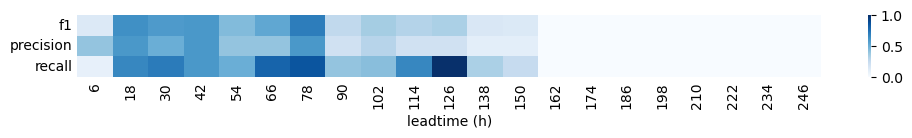

In [423]:
# add positives and negatives across stations
TP, FN, FP = ds_stn['tp'].sum('id'), ds_stn['fn'].sum('id'), ds_stn['fp'].sum('id')

# compute skill metrics
da_lt = xr.Dataset({'f1': 2 * TP / (2 * TP + FN + FP),
                 'precision': TP / (TP + FN),
                 'recall': TP / (TP + FP)}).to_array(dim='metric')

fig, ax = plt.subplots(figsize=(12,.8))
sns.heatmap(da_lt, cmap='Blues', ax=ax, vmin=0, vmax=1)
ax.set_xticklabels(da_lt.leadtime.data, rotation=90)
ax.set_yticklabels(da_lt.metric.data, rotation=0)
ax.tick_params(length=0)
ax.set(xlabel='leadtime (h)');

**Station skill**<br>
By summing up the hits and falses across leadtime.

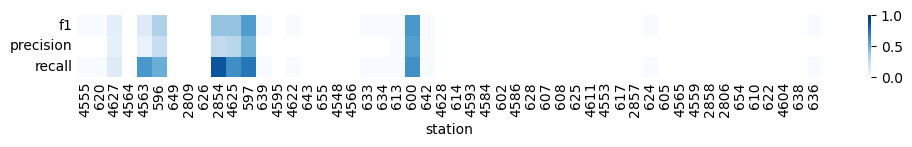

In [424]:
# add positives and negatives across leadtime
TP, FN, FP = ds_stn['tp'].sum('leadtime'), ds_stn['fn'].sum('leadtime'), ds_stn['fp'].sum('leadtime')

# compute skill metrics
da_id = xr.Dataset({'f1': 2 * TP / (2 * TP + FN + FP),
                 'precision': TP / (TP + FN),
                 'recall': TP / (TP + FP)}).to_array(dim='metric')

fig, ax = plt.subplots(figsize=(12, .8))
sns.heatmap(da_id, cmap='Blues', ax=ax, vmin=0, vmax=1)
ax.set_xticklabels(da_id.id.data, rotation=90)
ax.set_yticklabels(da_id.metric.data, rotation=0)
ax.tick_params(length=0)
ax.set(xlabel='station');

#### 3.5.1 Depending on leadtime

Fixed probability and window.

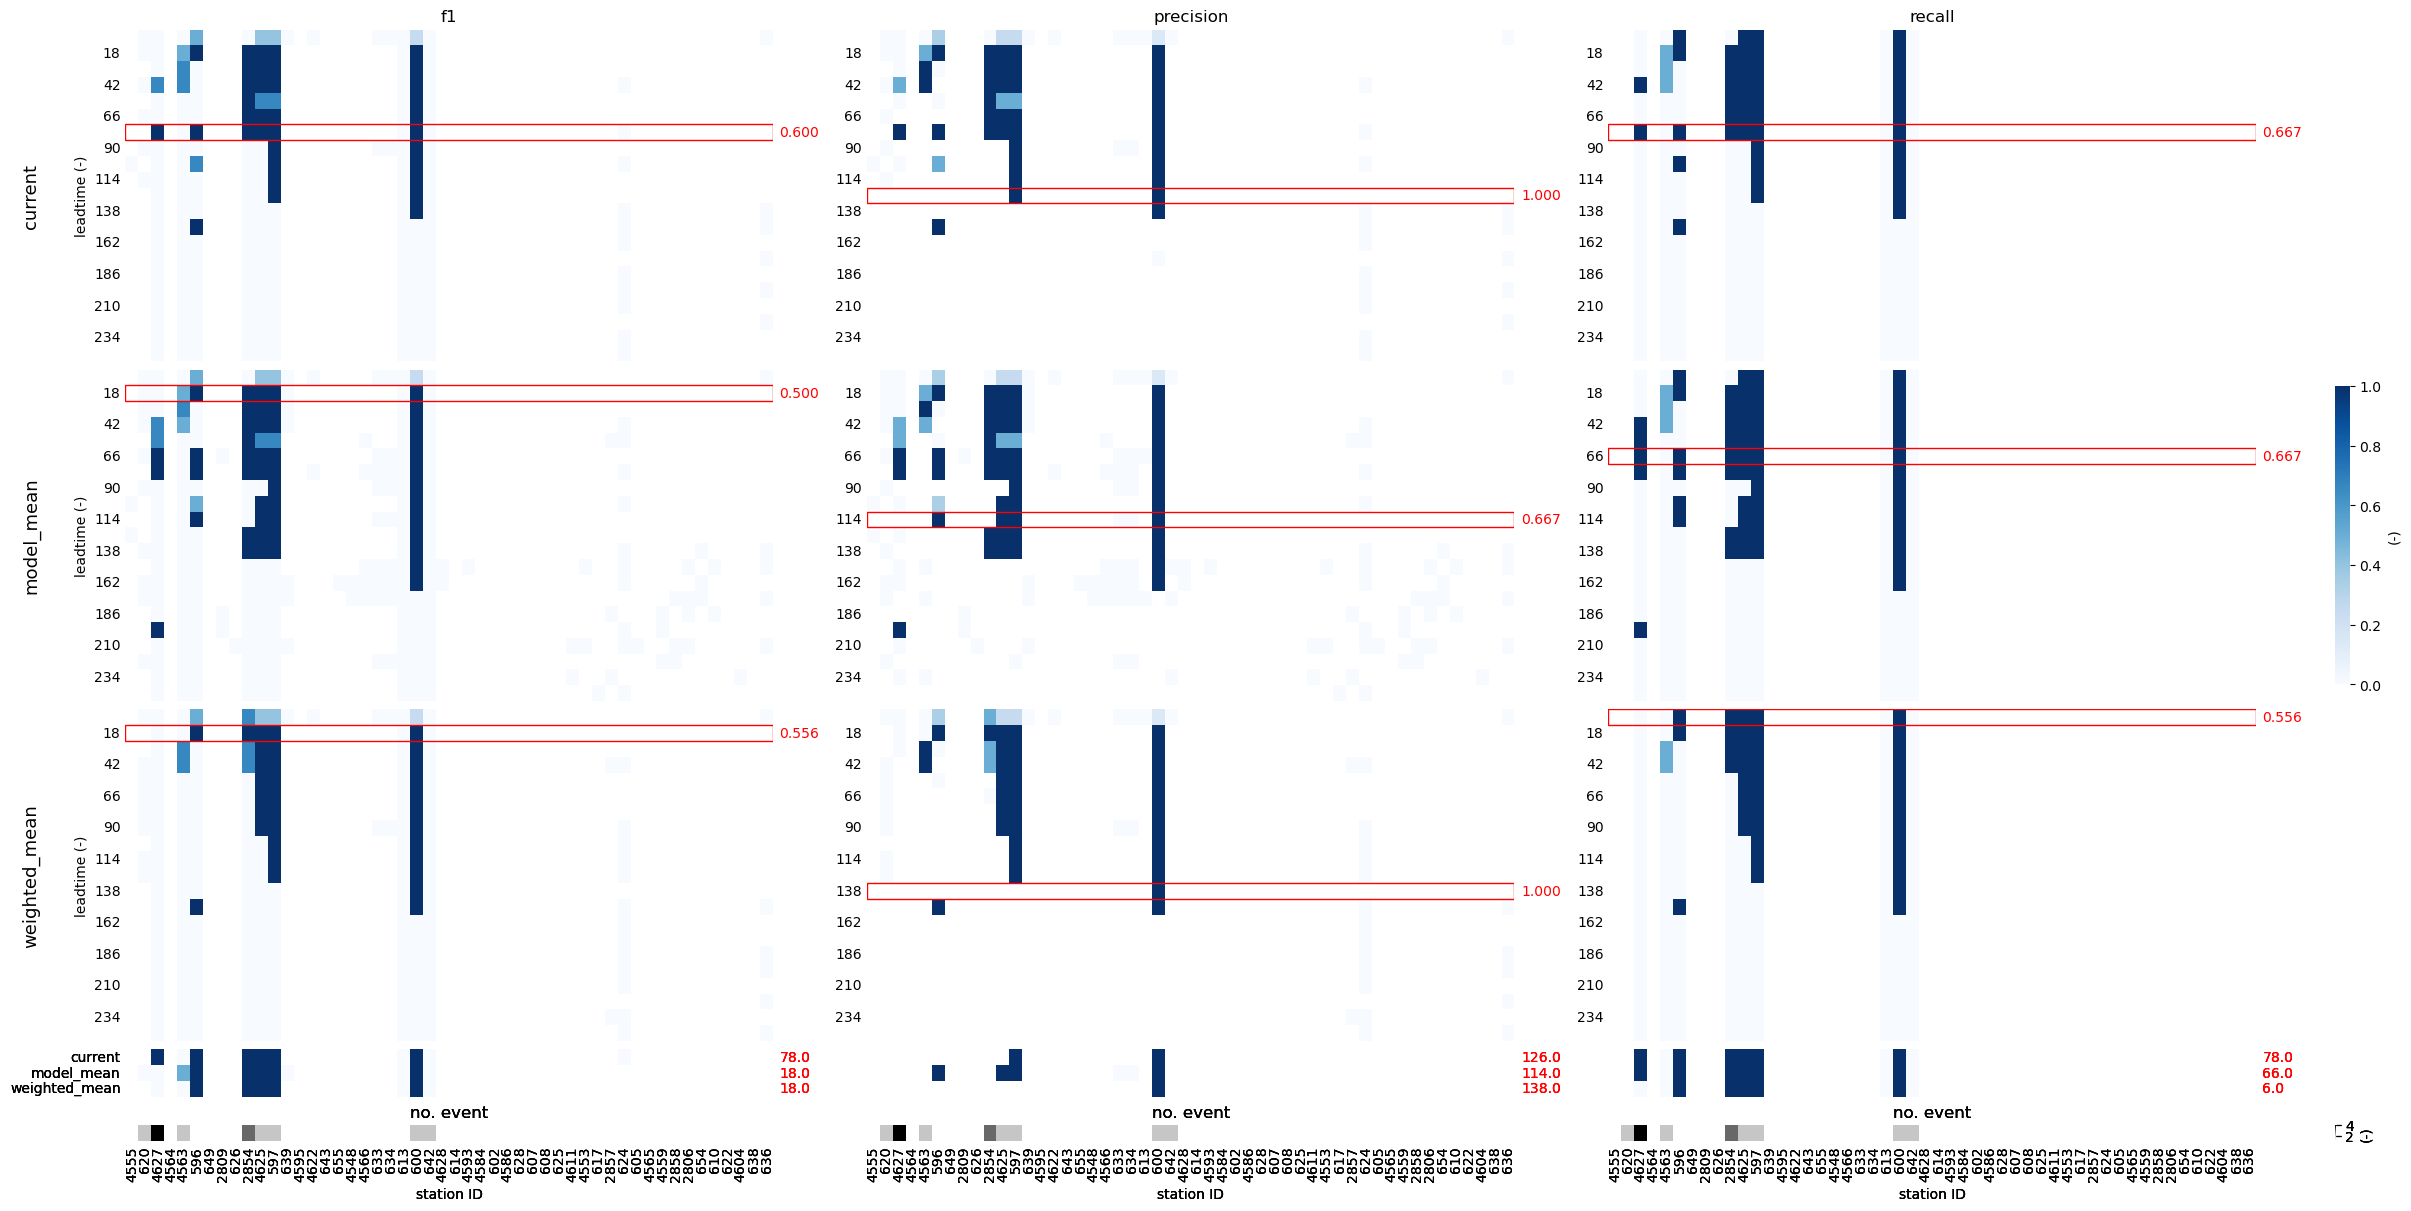

In [435]:
w = 3
p = .3

plot_skill(results5[['f1', 'precision', 'recall']].sel(probability=p, window=w),
           rean_events.sum(), xdim='id', ydim='leadtime', figsize=(24, 12))

#### 3.5.2 Depending on probability

Fixed window and mean across leadtime.

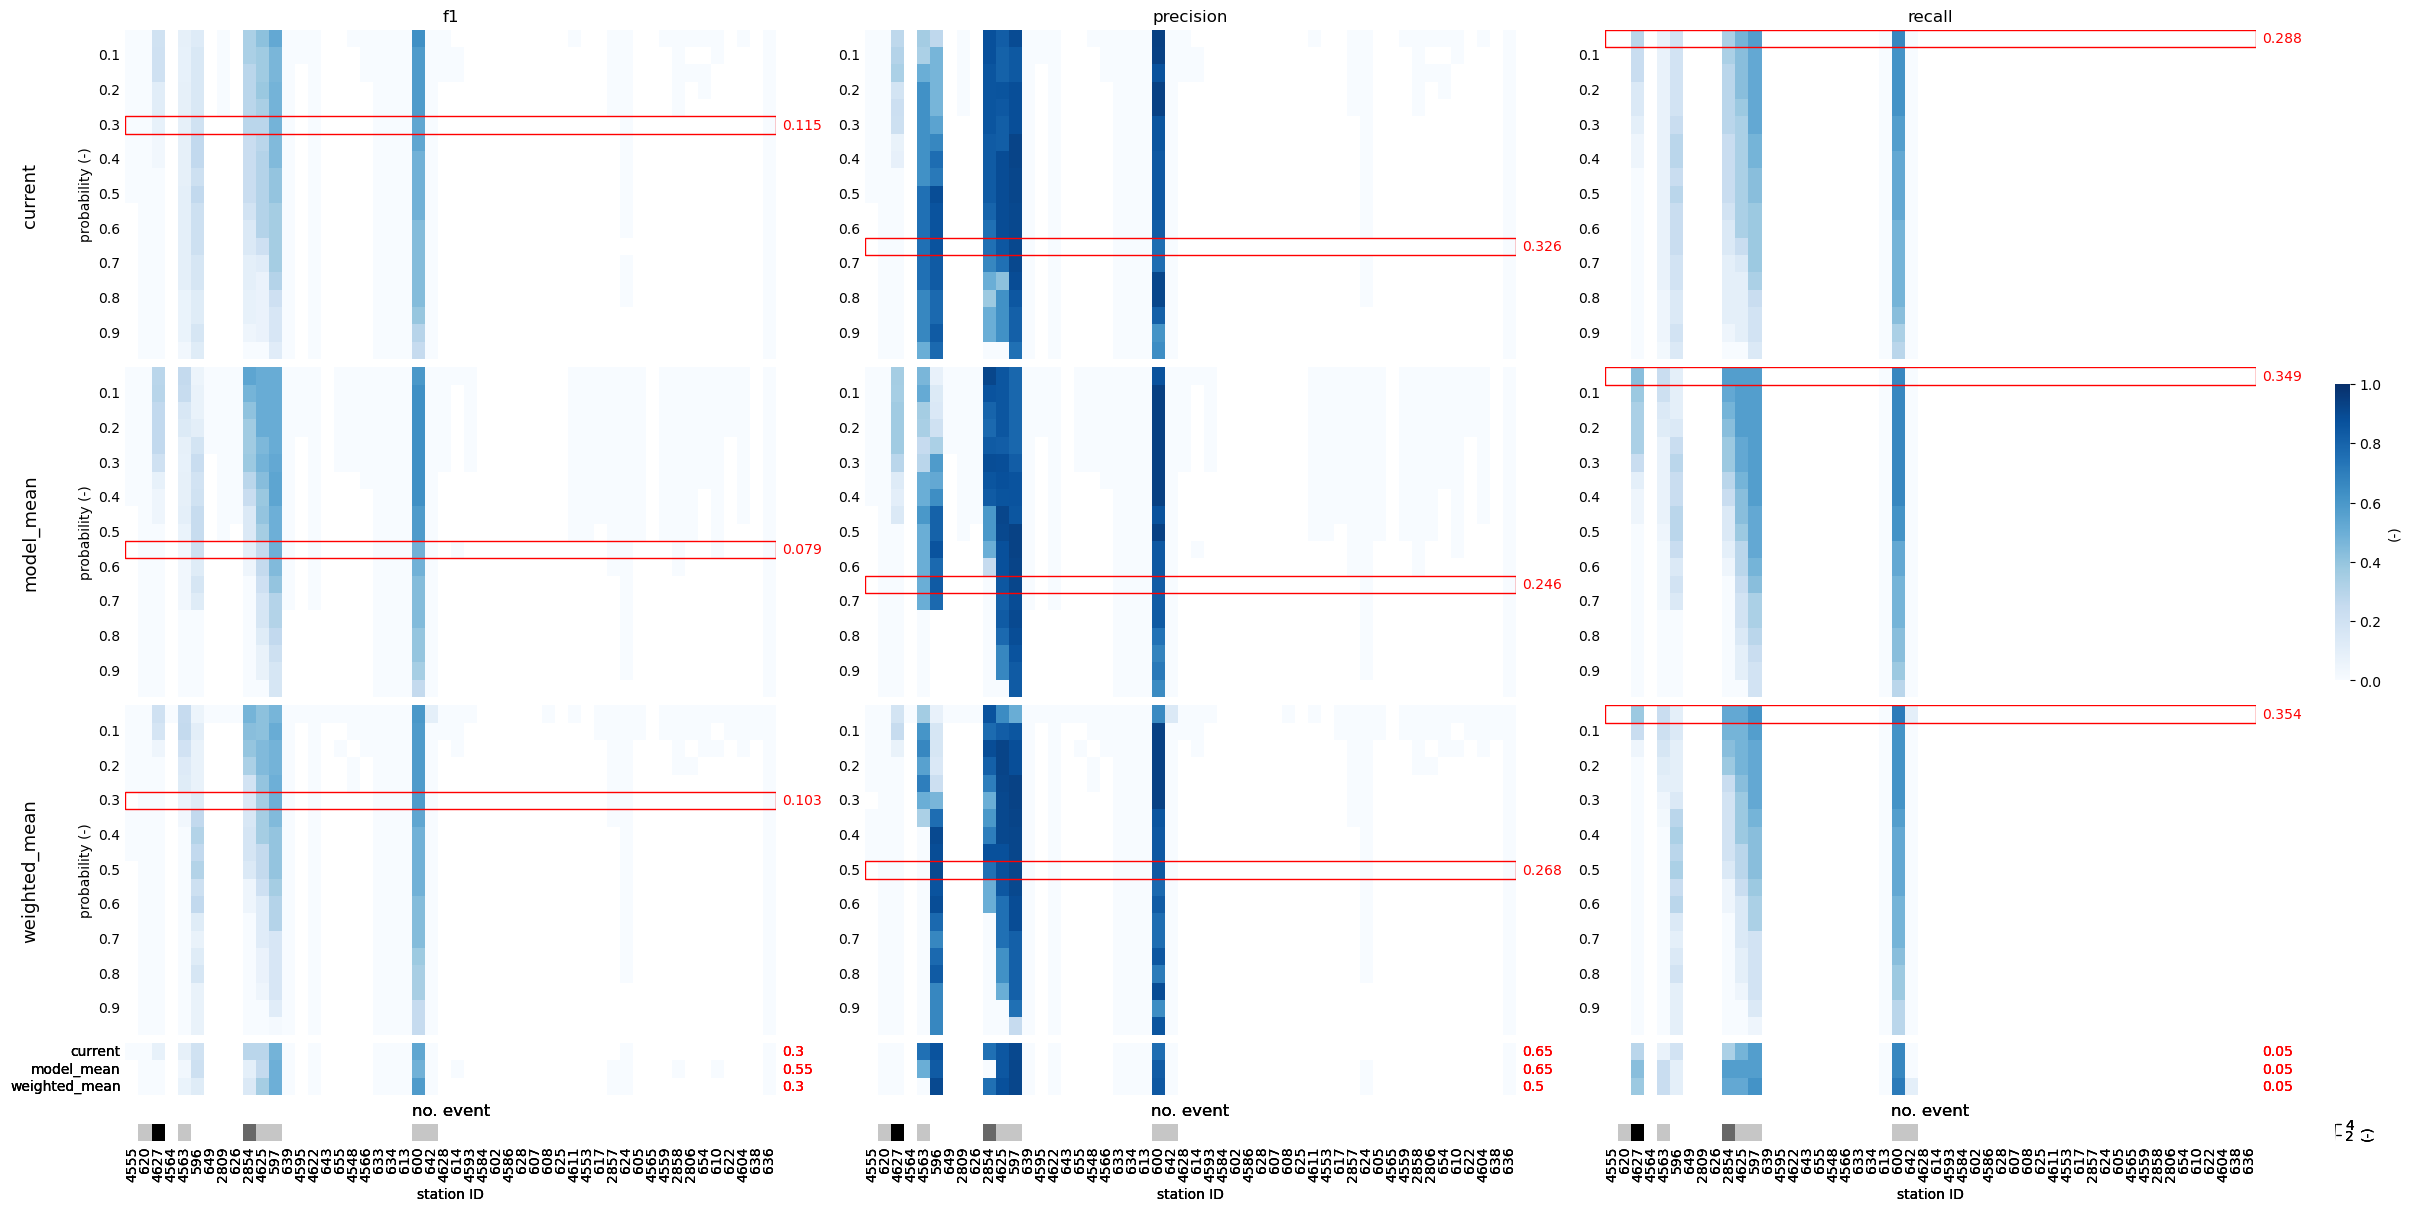

In [436]:
w = 3

plot_skill(results5[['f1', 'precision', 'recall']].sel(window=w).mean('leadtime'), rean_events.sum(), xdim='id', ydim='probability', figsize=(24, 12))

#### 3.5.3 Depending on probability and leadtime

Fixed window and mean across stations.

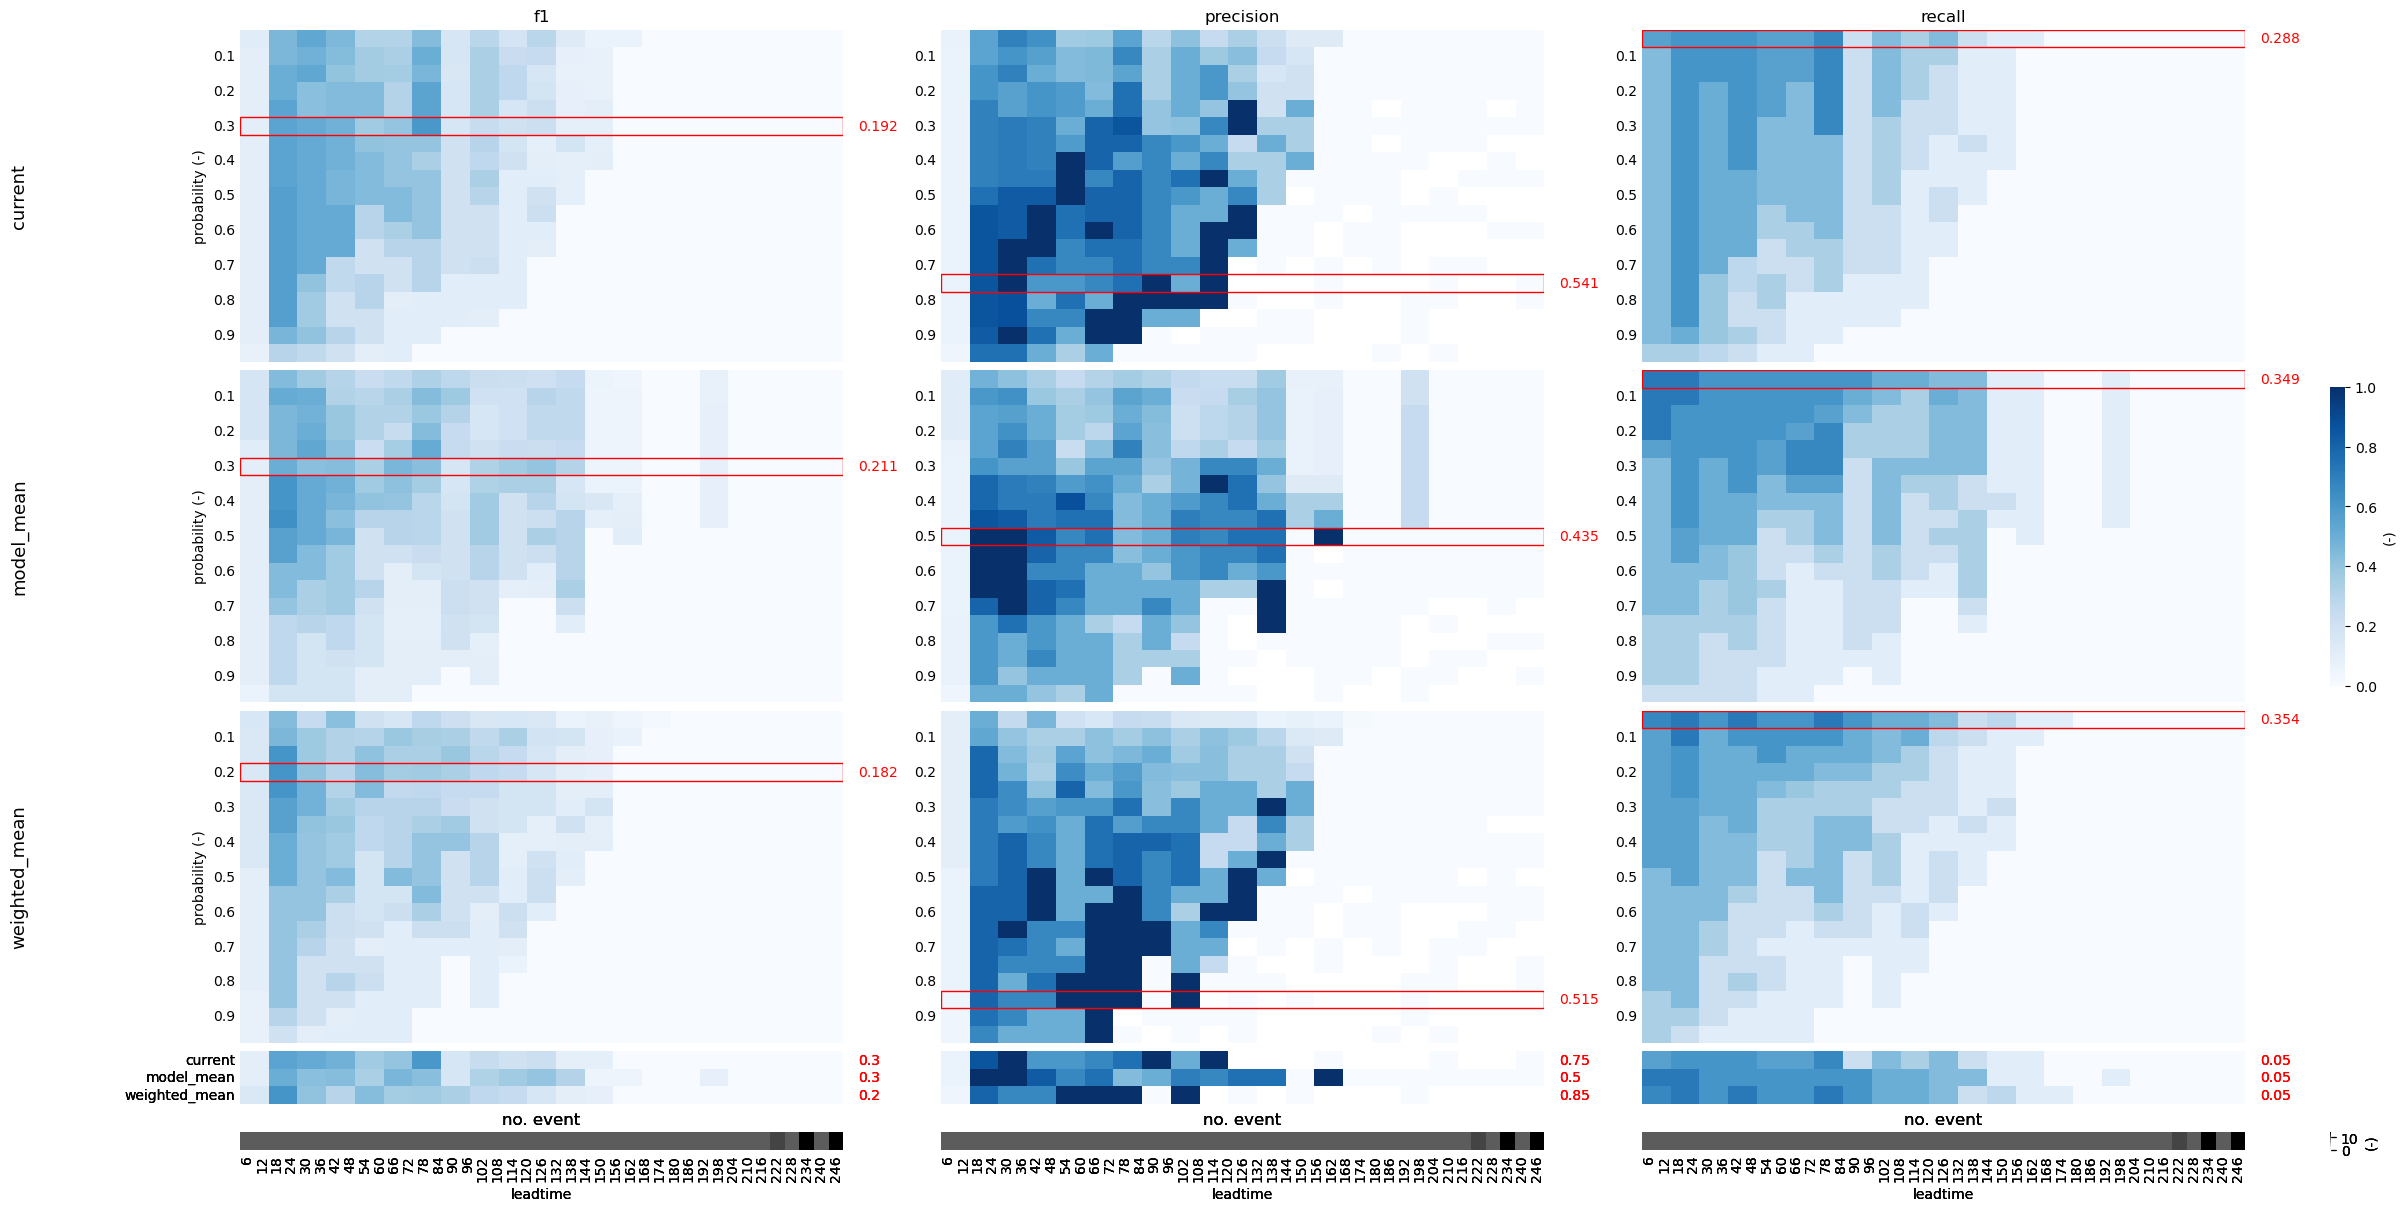

In [454]:
w = 3

events = obs_events.sum(['forecast', 'id']).to_pandas()
events.index = [(i + 1) * 6 for i in range(events.shape[0])]
plot_skill(results5[['f1', 'precision', 'recall']].sel(window=w).mean('id'), events,
           xdim='leadtime', ydim='probability', figsize=(24, 12))

### 3.3 Daily resampled

In [ ]:
# resample data daily
resample_dict = {'leadtime': 'd'}
obs_events_d = obs_events.resample(resample_dict).any()
pred_events_d = pred_events.resample(resample_dict).any()

# Dataset where results will be saved
results_d = xr.Dataset(coords={'model': ['current', 'model_mean', 'weighted_mean'],
                               'probability': probabilities,
                               'leadtime': obs_events_d.leadtime})

for i, stn in enumerate(stations.index):  
    
    print(f'Station {stn:>4d} ({i+1:>4d} of {n_stations:>4d})', end='\r')
    
    # array where station results will be saved temporarily
    results_station = np.zeros((len(results_d.model), len(results_d.probability), len(results_d.leadtime))) * np.nan
    
    for j, p in enumerate(probabilities):
        
        # PERFORMANCE
        # -----------
        
        for k, lt in enumerate(obs_events_d.leadtime):
            obs = obs_events_d[stn].sel(leadtime=lt)
            if obs.sum('forecast') == 0:
                continue
            else:
                pred = pred_events_d[stn].sel(probability=p, leadtime=lt).to_dataset(dim='model').drop_vars('probability')
                f1 = [f1_score(obs, pred[model]) for model in list(pred)]
                results_station[:, j, k] = f1
    
    results_d[stn] = xr.DataArray(results_station, coords=results_d.coords)

# merge all variables in a new dimension
da_list = [results_d[stn].expand_dims('id', axis=0).assign_coords(id=[stn]).rename('f1') for stn in list(results_d)]
results_d = xr.merge(da_list)['f1']

In [ ]:
nrows = len(results_d.model)
fig, axes = plt.subplots(nrows=nrows, figsize=(4, 10), sharex=True, sharey=True)

results_d_mean = results_d.mean('id')
vmax = np.ceil(results_d_mean.max() / .05) * .05

for i, (ax, model) in enumerate(zip(axes, results_d.model)):
    da = results_d_mean.sel(model=model)
    sns.heatmap(da, cmap='Blues', mask=da == 0, vmin=0, vmax=1, ax=ax,
                cbar_kws={'label': 'f1 (-)', 'shrink': .66})
    ax.set_ylabel('exceedance probability (-)')
    ax.set_yticks(np.arange(len(results_d.probability)))
    ax.set_yticklabels(results_d.probability.values, rotation=0)
    if i == nrows - 1:
        ax.set_xlabel('leadtime (d)')
    ax.set_xticklabels((results_d.leadtime / np.timedelta64(1, 'D')).values.astype(int), rotation=0)
    ax.set_title(model.data)

In [ ]:
results_d_mean.max()

***

In [ ]:
# stations with observed events
mask_stn = rean_events.sum() > 0
stations_ = stations.loc[mask_stn]

p = .5

ncols = len(results.model)

fig, axes = plt.subplots(ncols=ncols, figsize=(12, 4), sharex=True, sharey=True)

for ax, model in zip(axes, results.model.data):
    
    data = results.sel(id=stations_.index.to_list(), probability=p, model=model).data
    df = pd.DataFrame(data, index=stations_.index, columns=results.window)
    df['id'] = df.index
    df = pd.melt(df, id_vars='id', value_vars=[0, 1, 2, 3, 4])
    df.columns = ['id', 'window', 'f1']
    
    sns.boxplot(x=df.window, y=df.f1, ax=ax)
    
    ax.set(ylabel='f1-score (-)', ylim=(-.05, 1.05), title=model)

* The figures are very low even with a 4 timestep window, i.e., when we accept a 24 h error in the prediction of the onset of the event.
* The results are underrated because they take into account all leadtimes together. I should repeat the process grouping the f1 score by lead time.
* What if I simply check if a forecast predicts flooding (no matter when) and there actually was flooding during that forecast period.

***

**Daily resample**

In [ ]:
resample_dict = {'leadtime': 'd'}
events_daily = events_da.resample(resample_dict).any()
notification_d = xr.Dataset({variable: da.resample(resample_dict).any() for variable, da in notification.data_vars.items()})
notification_d = xr.Dataset(notification_d)

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 12), sharex=True)
for ax, (variable, da) in zip(axes, notification_d.data_vars.items()):
    heatmap_forecast(da, events, leadtime_grid=1, title=variable, ax=ax)
    heatmap_forecast(events_daily, vmax=2, cmap='Reds', alpha=.1, leadtime_grid=1, cbar=False, ax=ax)

In [ ]:
compute_performance(notification_d, events_daily)

**Rolling sum**

In [ ]:
w = 5
rolling_dict = {'leadtime': w}
mp = int(w / 2) + 1
notification_r = xr.Dataset({var: da.rolling(rolling_dict, center=True, min_periods=mp).sum() > 0 for var, da in notification.data_vars.items()})
events_r = events_da.rolling(rolling_dict, center=True, min_periods=mp).sum() > 0

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 12), sharex=True)
for ax, (variable, da) in zip(axes, notification_r.data_vars.items()):
    heatmap_forecast(da, events=None, vmax=2, title=variable, ax=ax)
    heatmap_forecast(events_da, vmax=2, cmap='Reds', alpha=.5, cbar=False, ax=ax)

In [ ]:
compute_performance(notification_r, events_da)

In [ ]:
compute_performance(notification_r, events_r)

In [ ]:
events_da.sum('leadtime')

In [ ]:
ev = events_da.isel(forecast=i)

In [ ]:
da = notification['model_mean']
da.sum('leadtime')

In [ ]:
i = 47

In [ ]:
y_true = events_da.isel(forecast=i).data.astype(float)

y_pred1 = da.isel(forecast=i).data.astype(float)
cm1 = confusion_matrix(y_true, y_pred1)

In [ ]:
y_pred0 = da.isel(forecast=i).shift(leadtime=1).data.astype(float)
y_pred0[0] = 0
cm0 = confusion_matrix(y_true, y_pred0)

In [ ]:
y_pred2 = da.isel(forecast=i).shift(leadtime=-1).data.astype(float)
y_pred2[-1] = 0
cm2 = confusion_matrix(y_true, y_pred2)

In [ ]:
np.max(cm0, cm1, cm2)

In [ ]:
# tmp = xr.DataArray([[0, 0, 1], [0, 1, 0], [1, 0, 0]], coords={'x': [1, 2, 3], 'y': [1, 2, 3]})
# tmp

# tmp.diff('y', label='upper')

# tmp.diff('y', label='lower')

## Compute formal notifications

* One probabilistic forecast (_EUE_ or _COSMO_) exceeds Q5:
    * With a probability of exceedance $\geq 30 \%$
    * In 3 consecutive forecasts
* One deterministic forecasts (_EUD_ or _DWD_) exceeds Q5
* Catchment area $\geq 2000 km^2$
* Lead time $\geq 48 h$

In [ ]:
stations_sel[['f1', 'recall', 'precision']] = np.nan
for i, (stn, Q5) in enumerate(zip(stations_sel.index, stations_sel.Q5)):

    ### REFORECAST

    # compute exceedance of Q5
    fore_exc = {model: compute_exceedance(files[model], stn, Q5) for model in models}
    # compute formal notifications
    notifications = compute_notifications(fore_exc, leadtime=4, probability=.3, persistence=3)

    ### REANALYSIS

    # Compute exceedance
    rea_exc = (reanalysis[stn] >= Q5).astype(int)

    # check if there was an event in each of the forecast windows
    events = []
    for forecast in notifications.forecast.values:
        start = forecast
        end = start + np.timedelta64(10, 'D')
        events.append(rea_exc[start:end].any())
    events = xr.DataArray(events, dims='forecast', coords={'forecast': notifications.forecast})

    # SKILL
    stations_sel.loc[stn, 'f1'] = f1_score(events, notifications)
    stations_sel.loc[stn, 'recall'] = recall_score(events, notifications)
    stations_sel.loc[stn, 'precision'] = precision_score(events, notifications)
    
    print('station {0:<3} of {1:<3} | {2:>4}:\t{3:.3f}'.format(i + 1, stations_sel.shape[0], stn, stations_sel.loc[stn, 'f1']))

In [ ]:
stations_sel[['f1', 'recall', 'precision']].describe()

In [ ]:
im = plt.scatter(stations_sel.LisfloodX, stations_sel.LisfloodY, s=stations_sel['DrainingArea.km2.LDD'] / 1000,
                 c=stations_sel.recall, cmap='virireanalysis', vmin=0, vmax=1)
plt.colorbar(im);

In [ ]:
stations_sel.loc[stations_sel.f1 == 0]

In [ ]:
stations_sel.to_csv(f'../data/stations_{catchment}.csv', float_format='%.3f')

For each station:
1. Identify flood events.
2